# Equity Feature Importance Analysis

**Comprehensive feature importance analysis using MLFinLab methods**

This notebook analyzes feature importance for our equity trading features using:
- **MDI (Mean Decrease Impurity)** - In-sample importance from Random Forest
- **MDA (Mean Decrease Accuracy)** - Out-of-sample importance via cross-validation
- **Feature Orthogonalization** - PCA-based deduplication to handle multicollinearity
- **Clustered Feature Importance** - Grouped analysis of related features

**Date:** October 20, 2025

## 1. Setup and Imports

In [43]:
# Setup path to import modules
import sys
from pathlib import Path

# Add project root and MLFinance to path
project_root = Path.cwd()
mlfinance_root = project_root / 'MLFinance'

for path in [project_root, mlfinance_root]:
    if str(path) not in sys.path:
        sys.path.insert(0, str(path))
        print(f"✓ Added {path} to Python path")

In [44]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

# MLFinLab feature importance - import from specific modules
from FinancialMachineLearning.feature_importance.importance import (
    mean_decrease_impurity,
    mean_decrease_accuracy,
    plot_feature_importance
)

# MLFinLab cross-validation (for time series)
from FinancialMachineLearning.cross_validation.cross_validation import PurgedKFold, cross_val_score

# Our custom modules
from fin_load_and_sequence import load_or_generate_sequences
from feature_config import FeatureConfig

print("✓ All imports successful")

✓ All imports successful


In [45]:
# Plotting setup
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Create output directory for plots
output_dir = Path('artifacts/feature_importance')
output_dir.mkdir(parents=True, exist_ok=True)
print(f"✓ Output directory: {output_dir}")

✓ Output directory: artifacts/feature_importance


## 2. Load Financial Features and Labels

Load our engineered features using the new market feature selection capability.

In [46]:
# Configuration
# Using 5 diverse tech tickers for robust feature importance analysis
# Mix of: mega-cap stable (AAPL), high-growth (NVDA), volatile (TSLA), 
#         e-commerce (AMZN), and semiconductor (AVGO)
TICKERS = ['AAPL', 'NVDA', 'TSLA', 'AMZN', 'AVGO']  # 5 diverse tickers
SEQ_LEN = 20
CONFIG_PRESET = 'comprehensive'  # ⭐ CHANGED: Test ALL features for complete analysis

# Market features to test
# ALL 6 market features for comprehensive analysis
MARKET_FEATURES = ['spy', 'vix', 'fvx', 'tyx', 'gold', 'jpyx']  # ⭐ CHANGED: All market features

# Barrier parameters (López de Prado triple barrier)
BARRIER_PARAMS = {
    'pt_sl': [2, 1],      # Asymmetric: 2× volatility for TP, 1× for SL
    'min_ret': 0.005,     # 0.5% minimum return threshold
    'num_days': 7,        # 7-day maximum holding period
    'lookback': 60        # 60-day volatility lookback
}

print(f"Tickers: {TICKERS}")
print(f"Market features: {MARKET_FEATURES}")
print(f"Barrier params: {BARRIER_PARAMS}")
print(f"\n⚠️ COMPREHENSIVE ANALYSIS MODE:")
print(f"   - Testing ALL {CONFIG_PRESET} features")
print(f"   - Including ALL 6 market features")
print(f"   - Using {len(TICKERS)} diverse tickers for robust feature selection")
print(f"   - This will identify features that work across different stock behaviors")

Tickers: ['AAPL', 'NVDA', 'TSLA', 'AMZN', 'AVGO']
Market features: ['spy', 'vix', 'fvx', 'tyx', 'gold', 'jpyx']
Barrier params: {'pt_sl': [2, 1], 'min_ret': 0.005, 'num_days': 7, 'lookback': 60}

⚠️ COMPREHENSIVE ANALYSIS MODE:
   - Testing ALL comprehensive features
   - Including ALL 6 market features
   - Using 5 diverse tickers for robust feature selection
   - This will identify features that work across different stock behaviors


In [90]:
# Reload module to pick up changes
import importlib
import fin_load_and_sequence
importlib.reload(fin_load_and_sequence)
from fin_load_and_sequence import load_or_generate_sequences

# Load sequences (this handles feature engineering, labeling, and sequencing)
print("Loading features and labels...\n")
X, y, dates, ldp_weights, returns, feature_names = load_or_generate_sequences(
    tickers=TICKERS,
    config_preset=CONFIG_PRESET,
    barrier_params=BARRIER_PARAMS,
    seq_len=SEQ_LEN,
    market_features=MARKET_FEATURES,
    use_cache=True,
    verbose=True
)

print(f"\n✓ Loaded data:")
print(f"  X shape: {X.shape} (samples, timesteps, features)")
print(f"  y shape: {y.shape}")
print(f"  Date range: {dates[0]} to {dates[-1]}")
print(f"  Features per timestep: {X.shape[2]}")
print(f"  Feature names: {len(feature_names)} total")
print(f"  First 5 features: {feature_names[:5]}")
print(f"  Last 5 features: {feature_names[-5:]}")


Loading features and labels...


🗄️  Loading cached sequences: cache/seq_AAPL_AMZN_AVGO_NVDA_TSLA_comprehensive_pt2_sl1_d7_len20_fvx_gold_jpyx_spy_tyx_vix.parquet
   ⚡ Skipping feature engineering and barrier generation


✅ Loaded 13172 sequences from cache
   Shape: (13172, 20, 115)
   Date range: 2015-04-06 to 2025-09-25
   LdP weights: range=[0.887, 2.681]
   Returns: range=[-0.3103, 0.3980]
⚠️  Cache load failed: 'EnhancedFinancialFeatures' object has no attribute 'get_all_feature_names'
   Regenerating sequences...

🔄 Generating sequences (no cache)
   Tickers: 5
   Config: comprehensive
   Barriers: pt=2, sl=1, days=7

📊 Loading market context features: ['spy', 'vix', 'fvx', 'tyx', 'gold', 'jpyx']
Loading market context data...
  ✓ Loaded spy : 2803 rows, date range 2015-01-01 to 2025-10-01
  ✓ Loaded vix : 2803 rows, date range 2015-01-01 to 2025-10-01
  ✓ Loaded fvx : 2803 rows, date range 2015-01-01 to 2025-10-01
  ✓ Loaded tyx : 2803 rows, date range 2015-01-01 to 2025-10-01
  ✓ Loaded gold: 2803 rows, date range 2015-01-01 to 2025-10-01
  ✓ Loaded jpyx: 2803 rows, date range 2015-01-01 to 2025-10-01
  Creating market features for: ['spy', 'vix', 'fvx', 'tyx', 'gold', 'jpyx']
  ✓ Created ^GSPC

2025-10-21 04:14:58.727022 100.0% concurrent_events done after 0.0 minutes. Remaining 0.0 minutes.
2025-10-21 04:14:59.258891 100.0% average_uniqueness done after 0.0 minutes. Remaining 0.0 minutes.
2025-10-21 04:14:59.258891 100.0% average_uniqueness done after 0.0 minutes. Remaining 0.0 minutes.


     Uniqueness: mean=0.186, range=[0.167, 0.457]
  ✅ AAPL: 2638 samples

Processing NVDA...
  Engineering features for 2703 samples...
  → Returns (multi-horizon)
  → Volatility (Yang-Zhang, Parkinson, Garman-Klass, Rogers-Satchell, Hodges-Tompkins)
  → Microstructure features
  → Microstructure features
  → Volume-weighted features
  → Momentum & oscillators
  → Trend indicators
  → Bollinger Bands
  → Price position indicators
  → Volume-weighted features
  → Momentum & oscillators
  → Trend indicators
  → Bollinger Bands
  → Price position indicators
  → Entropy & complexity
  → Entropy & complexity
  → Regime indicators
  → Regime indicators
  → Statistical properties (Skew, Kurtosis)
  → Statistical properties (Skew, Kurtosis)
  → Risk-adjusted metrics
  → Risk-adjusted metrics
  → Cleaning features...
  ✅ Created 109 features
  📈 Adding market context (6 features)...
      ^GSPC: 1 NaN values
      ^FVX: 1 NaN values
      ^TYX: 1 NaN values
      GC=F: 1 NaN values
     109 → 1

2025-10-21 04:16:20.425640 100.0% concurrent_events done after 0.0 minutes. Remaining 0.0 minutes.
2025-10-21 04:16:20.947266 100.0% average_uniqueness done after 0.0 minutes. Remaining 0.0 minutes.
2025-10-21 04:16:20.947266 100.0% average_uniqueness done after 0.0 minutes. Remaining 0.0 minutes.


     Uniqueness: mean=0.187, range=[0.167, 0.500]
  ✅ NVDA: 2639 samples

Processing TSLA...
  Engineering features for 2703 samples...
  → Returns (multi-horizon)
  → Volatility (Yang-Zhang, Parkinson, Garman-Klass, Rogers-Satchell, Hodges-Tompkins)
  → Microstructure features
  → Microstructure features
  → Volume-weighted features
  → Momentum & oscillators
  → Trend indicators
  → Bollinger Bands
  → Price position indicators
  → Volume-weighted features
  → Momentum & oscillators
  → Trend indicators
  → Bollinger Bands
  → Price position indicators
  → Entropy & complexity
  → Entropy & complexity
  → Regime indicators
  → Statistical properties (Skew, Kurtosis)
  → Regime indicators
  → Statistical properties (Skew, Kurtosis)
  → Risk-adjusted metrics
  → Risk-adjusted metrics
  → Cleaning features...
  ✅ Created 109 features
  📈 Adding market context (6 features)...
      ^GSPC: 1 NaN values
      ^FVX: 1 NaN values
      ^TYX: 1 NaN values
      GC=F: 1 NaN values
     109 → 1

2025-10-21 04:17:40.321822 100.0% concurrent_events done after 0.0 minutes. Remaining 0.0 minutes.
2025-10-21 04:17:40.843918 100.0% average_uniqueness done after 0.0 minutes. Remaining 0.0 minutes.
2025-10-21 04:17:40.843918 100.0% average_uniqueness done after 0.0 minutes. Remaining 0.0 minutes.


     Uniqueness: mean=0.187, range=[0.167, 0.521]
  ✅ TSLA: 2639 samples

Processing AMZN...
  Engineering features for 2703 samples...
  → Returns (multi-horizon)
  → Volatility (Yang-Zhang, Parkinson, Garman-Klass, Rogers-Satchell, Hodges-Tompkins)
  → Microstructure features
  → Microstructure features
  → Volume-weighted features
  → Momentum & oscillators
  → Trend indicators
  → Bollinger Bands
  → Price position indicators
  → Volume-weighted features
  → Momentum & oscillators
  → Trend indicators
  → Bollinger Bands
  → Price position indicators
  → Entropy & complexity
  → Entropy & complexity
  → Regime indicators
  → Statistical properties (Skew, Kurtosis)
  → Regime indicators
  → Statistical properties (Skew, Kurtosis)
  → Risk-adjusted metrics
  → Risk-adjusted metrics
  → Cleaning features...
  ✅ Created 109 features
  📈 Adding market context (6 features)...
      ^GSPC: 1 NaN values
      ^FVX: 1 NaN values
      ^TYX: 1 NaN values
      GC=F: 1 NaN values
     109 → 1

2025-10-21 04:19:00.613480 100.0% concurrent_events done after 0.0 minutes. Remaining 0.0 minutes.
2025-10-21 04:19:01.130623 100.0% average_uniqueness done after 0.0 minutes. Remaining 0.0 minutes.
2025-10-21 04:19:01.130623 100.0% average_uniqueness done after 0.0 minutes. Remaining 0.0 minutes.


     Uniqueness: mean=0.188, range=[0.167, 0.500]
  ✅ AMZN: 2638 samples

Processing AVGO...
  Engineering features for 2703 samples...
  → Returns (multi-horizon)
  → Volatility (Yang-Zhang, Parkinson, Garman-Klass, Rogers-Satchell, Hodges-Tompkins)
  → Microstructure features
  → Microstructure features
  → Volume-weighted features
  → Momentum & oscillators
  → Trend indicators
  → Bollinger Bands
  → Price position indicators
  → Volume-weighted features
  → Momentum & oscillators
  → Trend indicators
  → Bollinger Bands
  → Price position indicators
  → Entropy & complexity
  → Entropy & complexity
  → Regime indicators
  → Statistical properties (Skew, Kurtosis)
  → Regime indicators
  → Statistical properties (Skew, Kurtosis)
  → Risk-adjusted metrics
  → Risk-adjusted metrics
  → Cleaning features...
  ✅ Created 109 features
  📈 Adding market context (6 features)...
      ^GSPC: 1 NaN values
      ^FVX: 1 NaN values
      ^TYX: 1 NaN values
      GC=F: 1 NaN values
     109 → 1

2025-10-21 04:20:19.872111 100.0% concurrent_events done after 0.0 minutes. Remaining 0.0 minutes.
2025-10-21 04:20:20.404017 100.0% average_uniqueness done after 0.0 minutes. Remaining 0.0 minutes.
2025-10-21 04:20:20.404017 100.0% average_uniqueness done after 0.0 minutes. Remaining 0.0 minutes.


     Uniqueness: mean=0.187, range=[0.167, 0.500]
  ✅ AVGO: 2638 samples

📊 Combining data from 5 tickers...
✅ Combined: 13192 samples, 115 features
   Date range: 2015-03-31 to 2025-09-25
   Feature names: ['log_return_1d', 'log_return_2d', 'log_return_3d', 'log_return_5d', 'log_return_10d']... (115 total)

🔄 Creating sequences (seq_len=20)...
✅ Generated 13172 sequences
   Filtered 0 NaN sequences
   Shape: (13172, 20, 115)
   LdP weights: range=[0.887, 2.681]
   Returns: range=[-0.3103, 0.3980]

💾 Saving to cache: cache/seq_AAPL_AMZN_AVGO_NVDA_TSLA_comprehensive_pt2_sl1_d7_len20_fvx_gold_jpyx_spy_tyx_vix.parquet
✅ Generated 13172 sequences
   Filtered 0 NaN sequences
   Shape: (13172, 20, 115)
   LdP weights: range=[0.887, 2.681]
   Returns: range=[-0.3103, 0.3980]

💾 Saving to cache: cache/seq_AAPL_AMZN_AVGO_NVDA_TSLA_comprehensive_pt2_sl1_d7_len20_fvx_gold_jpyx_spy_tyx_vix.parquet
✅ Cache saved (291.5 MB)

✓ Loaded data:
  X shape: (13172, 20, 115) (samples, timesteps, features)
 

## 3. Prepare Data for Random Forest

Random Forest expects 2D input (samples × features), so we need to flatten our sequences.
We'll use the **last timestep** of each sequence as it contains the most recent information.

In [93]:
# Extract last timestep from sequences
# Shape: (samples, seq_len, features) → (samples, features)
X_2d = X[:, -1, :]  # Last timestep only

print(f"X_2d shape: {X_2d.shape}")
print(f"y shape: {y.shape}")
print(f"\nLabel distribution:")
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    pct = count / len(y) * 100
    label_name = {-1: 'DOWN/SL', 0: 'TIMEOUT', 1: 'UP/TP'}.get(label, f'Label {label}')
    print(f"  {label_name:12} ({label:2}): {count:5} ({pct:5.1f}%)")

X_2d shape: (13172, 115)
y shape: (13172,)

Label distribution:
  DOWN/SL      (-1):  2919 ( 22.2%)
  TIMEOUT      ( 0):  8306 ( 63.1%)
  UP/TP        ( 1):  1947 ( 14.8%)


In [94]:
# Verify feature names match feature count
print(f"Feature count verification:")
print(f"  X_2d features: {X_2d.shape[1]}")
print(f"  Feature names: {len(feature_names)}")

if len(feature_names) == X_2d.shape[1]:
    print(f"  ✅ Perfect match!")
    all_feature_names = feature_names
else:
    print(f"  ⚠️ Mismatch! Using generic names as fallback")
    all_feature_names = [f'feature_{i}' for i in range(X_2d.shape[1])]

print(f"\nFirst 10 features: {all_feature_names[:10]}")
print(f"Last 5 features: {all_feature_names[-5:]}")


Feature count verification:
  X_2d features: 115
  Feature names: 115
  ✅ Perfect match!

First 10 features: ['log_return_1d', 'log_return_2d', 'log_return_3d', 'log_return_5d', 'log_return_10d', 'log_return_20d', 'return_acceleration', 'volatility_yz_10', 'volatility_yz_20', 'volatility_yz_60']
Last 5 features: ['^VIX', '^FVX', '^TYX', 'GC=F', 'JPY=X']


In [95]:
# Create DataFrame for easier handling
X_df = pd.DataFrame(X_2d, columns=all_feature_names, index=dates)
y_series = pd.Series(y, index=dates, name='label')

print("\nFeature DataFrame:")
print(X_df.head())
print(f"\nShape: {X_df.shape}")
print(f"NaN count: {X_df.isna().sum().sum()}")


Feature DataFrame:
            log_return_1d  log_return_2d  log_return_3d  log_return_5d  \
2015-04-06       0.016069       0.024643       0.023196       0.032724   
2015-04-07      -0.001432       0.005027       0.000159      -0.038256   
2015-04-07       0.008730       0.037283       0.039660       0.018002   
2015-04-07       0.000738       0.062163       0.080178       0.064417   
2015-04-07      -0.010578       0.005491       0.014066      -0.002853   

            log_return_10d  log_return_20d  return_acceleration  \
2015-04-06        0.011451        0.005907             0.007494   
2015-04-07       -0.067618       -0.008684            -0.007890   
2015-04-07       -0.038147       -0.033734            -0.019824   
2015-04-07        0.017971        0.062792            -0.060687   
2015-04-07       -0.009478       -0.008928            -0.026647   

            volatility_yz_10  volatility_yz_20  volatility_yz_60  ...  \
2015-04-06          0.179266          0.210159          0.2

In [105]:
# VERIFICATION: Check feature name alignment
print("="*80)
print("FEATURE NAME ALIGNMENT VERIFICATION")
print("="*80)

print(f"\n1. Dimensions:")
print(f"   X_df shape: {X_df.shape} (samples × features)")
print(f"   X_df columns: {len(X_df.columns)}")
print(f"   feature_names: {len(feature_names)}")
print(f"   all_feature_names: {len(all_feature_names)}")

print(f"\n2. Are X_df columns == all_feature_names?")
match = list(X_df.columns) == all_feature_names
print(f"   {match}")

if not match:
    print(f"\n   ⚠️ MISMATCH DETECTED!")
    print(f"\n   First 5 in X_df.columns: {list(X_df.columns[:5])}")
    print(f"   First 5 in all_feature_names: {all_feature_names[:5]}")
    
    # Find differences
    for i, (col, name) in enumerate(zip(X_df.columns, all_feature_names)):
        if col != name:
            print(f"\n   Mismatch at index {i}:")
            print(f"      X_df.columns[{i}]: {col}")
            print(f"      all_feature_names[{i}]: {name}")
            if i >= 5:
                print(f"   (stopping after first few mismatches...)")
                break
else:
    print(f"   ✅ Perfect alignment!")

print(f"\n3. Sample values check (first feature, first 5 samples):")
first_feature_name = all_feature_names[0]
print(f"   Feature: {first_feature_name}")
print(f"   Values from X_df['{first_feature_name}']: {X_df[first_feature_name].iloc[:5].values}")
print(f"   Values from X_df.iloc[:, 0]: {X_df.iloc[:, 0].values[:5]}")
values_match = np.allclose(X_df[first_feature_name].iloc[:5].values, X_df.iloc[:, 0].values[:5])
print(f"   Match: {values_match}")

print(f"\n4. Market features check (last 6 should be market features):")
print(f"   Expected: {MARKET_FEATURES}")
market_feature_map = {
    'spy': '^GSPC',
    'vix': '^VIX',
    'fvx': '^FVX',
    'tyx': '^TYX',
    'gold': 'GC=F',
    'jpyx': 'JPY=X'
}
expected_market = [market_feature_map[f] for f in MARKET_FEATURES]
actual_last_6 = all_feature_names[-6:]
print(f"   Expected last 6: {expected_market}")
print(f"   Actual last 6: {actual_last_6}")
market_match = expected_market == actual_last_6
print(f"   Match: {market_match}")

if market_match:
    print(f"\n   ✅ Market features correctly positioned at the end!")
else:
    print(f"\n   ⚠️ Market feature order mismatch!")

print(f"\n5. Statistics alignment check:")
print(f"   First feature ({all_feature_names[0]}):")
print(f"      Mean: {X_df.iloc[:, 0].mean():.6f}")
print(f"      Std:  {X_df.iloc[:, 0].std():.6f}")
print(f"      Min:  {X_df.iloc[:, 0].min():.6f}")
print(f"      Max:  {X_df.iloc[:, 0].max():.6f}")

print(f"\n   Last feature ({all_feature_names[-1]}):")
print(f"      Mean: {X_df.iloc[:, -1].mean():.6f}")
print(f"      Std:  {X_df.iloc[:, -1].std():.6f}")
print(f"      Min:  {X_df.iloc[:, -1].min():.6f}")
print(f"      Max:  {X_df.iloc[:, -1].max():.6f}")

print(f"\n" + "="*80)
print("✅ VERIFICATION COMPLETE")
print("="*80)


FEATURE NAME ALIGNMENT VERIFICATION

1. Dimensions:
   X_df shape: (2636, 115) (samples × features)
   X_df columns: 115
   feature_names: 115
   all_feature_names: 115

2. Are X_df columns == all_feature_names?
   True
   ✅ Perfect alignment!

3. Sample values check (first feature, first 5 samples):
   Feature: log_return_1d
   Values from X_df['log_return_1d']: [ 0.01606885 -0.00699974  0.00729235  0.02289696 -0.003149  ]
   Values from X_df.iloc[:, 0]: [ 0.01606885 -0.00699974  0.00729235  0.02289696 -0.003149  ]
   Match: True

4. Market features check (last 6 should be market features):
   Expected: ['spy', 'vix', 'fvx', 'tyx', 'gold', 'jpyx']
   Expected last 6: ['^GSPC', '^VIX', '^FVX', '^TYX', 'GC=F', 'JPY=X']
   Actual last 6: ['^GSPC', '^VIX', '^FVX', '^TYX', 'GC=F', 'JPY=X']
   Match: True

   ✅ Market features correctly positioned at the end!

5. Statistics alignment check:
   First feature (log_return_1d):
      Mean: 0.001858
      Std:  0.026225
      Min:  -0.174763
   

## 4. Setup Purged K-Fold Cross-Validation

For time series, we need to avoid **data leakage** from overlapping samples.
MLFinLab's `PurgedKFold` removes test samples that overlap with training period.

In [96]:
# Create time-based index for purging
# We need t1 (end time) for each sample - use dates + holding period
t1 = pd.Series(
    dates + pd.Timedelta(days=BARRIER_PARAMS['num_days']),
    index=dates
)

# Create PurgedKFold cross-validator
N_SPLITS = 5
EMBARGO = 0.01  # 1% embargo period between train/test

cv_gen = PurgedKFold(
    n_splits=N_SPLITS,
    samples_info_sets=t1,
    pct_embargo=EMBARGO
)

print(f"✓ Created PurgedKFold cross-validator:")
print(f"  Number of splits: {N_SPLITS}")
print(f"  Embargo: {EMBARGO*100}%")
print(f"  Total samples: {len(X_df)}")

# Verify splits
for i, (train_idx, test_idx) in enumerate(cv_gen.split(X_df)):
    print(f"  Fold {i+1}: Train={len(train_idx)}, Test={len(test_idx)}")

✓ Created PurgedKFold cross-validator:
  Number of splits: 5
  Embargo: 1.0%
  Total samples: 13172
  Fold 1: Train=10381, Test=2635
  Fold 2: Train=10377, Test=2635


  Fold 3: Train=10377, Test=2634
  Fold 4: Train=10377, Test=2634
  Fold 5: Train=10536, Test=2634


In [97]:
# FIX: Remove duplicate dates (multi-ticker data causes duplicate timestamps)
# Keep last occurrence of each duplicate - cleaner than microsecond offsets
# CRITICAL: Must run this before any cross-validation to avoid slice object errors
print("\n⚠️ Checking for duplicate dates (multi-ticker data)...")

# Check for duplicates
n_duplicates = dates.duplicated().sum()
if n_duplicates > 0:
    print(f"  Found {n_duplicates} duplicate dates - removing duplicates...")
    original_count = len(X_df)
    
    # Remove duplicates keeping last occurrence
    mask = ~X_df.index.duplicated(keep='last')
    X_df = X_df.loc[mask]
    y_series = y_series.loc[mask]
    dates = X_df.index
    
    print(f"  ✓ Removed {original_count - len(X_df)} duplicate rows")
    print(f"  ✓ Remaining samples: {len(X_df)}")
    
    # Recreate t1 with unique dates
    t1 = pd.Series(
        dates + pd.Timedelta(days=BARRIER_PARAMS['num_days']),
        index=dates
    )
    
    # Recreate PurgedKFold with new unique index
    cv_gen = PurgedKFold(
        n_splits=N_SPLITS,
        samples_info_sets=t1,
        pct_embargo=EMBARGO
    )
    
    print(f"  ✓ Recreated PurgedKFold with unique index")
    print(f"  ✓ Verification: {dates.duplicated().sum()} duplicates remaining")
else:
    print(f"  ✓ No duplicate dates found")


⚠️ Checking for duplicate dates (multi-ticker data)...
  Found 10536 duplicate dates - removing duplicates...
  ✓ Removed 10536 duplicate rows
  ✓ Remaining samples: 2636
  ✓ Recreated PurgedKFold with unique index
  ✓ Verification: 0 duplicates remaining


## 5. Train Random Forest Classifier

**⚠️ Important: Regularization for Real Financial Data**

The MLFinance reference notebook uses **synthetic data** with clear signal patterns and doesn't need regularization. However, **real financial markets** have:
- Much weaker signal-to-noise ratio
- Non-stationary patterns and regime changes
- High dimensionality relative to sample size
- Spurious correlations and noise

Therefore, we add **regularization parameters** to prevent overfitting:

**López de Prado's recommendations:**
- `max_features=1` to avoid masking effect (✓ kept)
- `class_weight='balanced_subsample'` for imbalanced labels (✓ kept)
- `criterion='entropy'` for better feature importance (✓ kept)
- `oob_score=True` for out-of-bag validation (✓ kept)

**Additional regularization for real financial data:**
- `max_depth=5` to limit tree complexity and prevent memorization
- `min_samples_leaf=50` to ensure statistically meaningful leaf nodes (~1% of data)

In [98]:
# Random Forest configuration FOR REAL FINANCIAL DATA
# (differs from MLFinance synthetic data examples)
rf_params = {
    'n_estimators': 1000,              # More trees = more stable estimates
    'criterion': 'entropy',            # Better for feature importance
    'max_features': 1,                 # Avoid masking effect (LdP recommendation)
    'max_depth': 5,                    # ⭐ NEW: Limit tree depth (prevents overfitting)
    'min_samples_leaf': 50,            # ⭐ NEW: Min samples per leaf (~1% of 5257 samples)
    'min_weight_fraction_leaf': 0.0,
    'class_weight': 'balanced_subsample',  # Handle class imbalance
    'oob_score': True,                 # Out-of-bag validation
    'random_state': 42,
    'n_jobs': -1,                      # Use all cores
    'verbose': 0
}

print("Random Forest Configuration:")
for key, value in rf_params.items():
    print(f"  {key:25} = {value}")
    
print("\n⚠️ Note: Added max_depth & min_samples_leaf for real financial data")
print("   (MLFinance examples use synthetic data without these constraints)")

Random Forest Configuration:
  n_estimators              = 1000
  criterion                 = entropy
  max_features              = 1
  max_depth                 = 5
  min_samples_leaf          = 50
  min_weight_fraction_leaf  = 0.0
  class_weight              = balanced_subsample
  oob_score                 = True
  random_state              = 42
  n_jobs                    = -1
  verbose                   = 0

⚠️ Note: Added max_depth & min_samples_leaf for real financial data
   (MLFinance examples use synthetic data without these constraints)


In [99]:
# Train Random Forest
print("\nTraining Random Forest...")
forest = RandomForestClassifier(**rf_params)

# Fit on full dataset (we'll use CV for MDA later)
fit = forest.fit(X_df, y_series)

print(f"✓ Training complete")
print(f"  OOB Score: {forest.oob_score_:.4f}")
print(f"  Number of trees: {forest.n_estimators}")
print(f"  Number of features: {forest.n_features_in_}")
oob_score = fit.oob_score_


Training Random Forest...
✓ Training complete
  OOB Score: 0.4613
  Number of trees: 1000
  Number of features: 115
✓ Training complete
  OOB Score: 0.4613
  Number of trees: 1000
  Number of features: 115


In [100]:
# Calculate in-sample and out-of-sample accuracy
y_pred_train = forest.predict(X_df)
train_accuracy = accuracy_score(y_series, y_pred_train)
oob_score = forest.oob_score_

print(f"\nModel Performance:")
print(f"  Train Accuracy: {train_accuracy:.4f}")
print(f"  OOB Accuracy:   {oob_score:.4f}")
print(f"  Difference:     {train_accuracy - oob_score:.4f}")

if train_accuracy - oob_score > 0.1:
    print("  ⚠️ Large gap suggests overfitting")
elif train_accuracy - oob_score > 0.05:
    print("  ⚠️ Moderate overfitting detected")
else:
    print("  ✓ Good generalization")


Model Performance:
  Train Accuracy: 0.5789
  OOB Accuracy:   0.4613
  Difference:     0.1176
  ⚠️ Large gap suggests overfitting


## 6. MDI Feature Importance (Mean Decrease Impurity)

**In-sample** importance based on how much each feature reduces impurity in the forest.

**Advantages:**
- Fast to compute (already calculated during training)
- Captures feature interactions in trees

**Limitations:**
- In-sample only (can overfit)
- Affected by substitution effects (correlated features diluted)
- Biased toward high-cardinality features

In [109]:
# Calculate MDI using MLFinLab
print("Calculating MDI feature importance...")

mdi = mean_decrease_impurity(
    forest,
    X_df.columns
)

print(f"✓ MDI calculation complete")
print(f"\nTop 10 features by MDI:")
print(mdi.head(20))

Calculating MDI feature importance...
✓ MDI calculation complete

Top 10 features by MDI:
                             mean       std
log_return_1d            0.008372  0.000176
log_return_2d            0.011055  0.000209
log_return_3d            0.008744  0.000202
log_return_5d            0.009714  0.000211
log_return_10d           0.009443  0.000169
log_return_20d           0.008328  0.000144
return_acceleration      0.008666  0.000164
volatility_yz_10         0.008204  0.000160
volatility_yz_20         0.010088  0.000231
volatility_yz_60         0.009274  0.000179
volatility_parkinson_10  0.008518  0.000148
volatility_parkinson_20  0.008541  0.000159
volatility_gk_20         0.008449  0.000178
volatility_cc_20         0.009989  0.000173
volatility_cc_60         0.010520  0.000209
volatility_rs_20         0.008186  0.000197
volatility_rs_60         0.010182  0.000184
volatility_ht_20         0.009565  0.000209
volatility_ht_60         0.010939  0.000210
vol_ratio_short_long     0.008

In [110]:
# Examine MDI structure
print("="*80)
print("MDI FEATURE IMPORTANCE STRUCTURE")
print("="*80)

print(f"\n1. MDI Type: {type(mdi)}")
print(f"   Shape: {mdi.shape}")
print(f"   Columns: {list(mdi.columns)}")

print(f"\n2. Index (feature names):")
print(f"   Type: {type(mdi.index)}")
print(f"   First 5: {list(mdi.index[:5])}")
print(f"   Last 5: {list(mdi.index[-5:])}")

print(f"\n3. Is it already sorted?")
print(f"   First value (mean): {mdi['mean'].iloc[0]:.6f}")
print(f"   Last value (mean): {mdi['mean'].iloc[-1]:.6f}")
print(f"   Max value (mean): {mdi['mean'].max():.6f}")
print(f"   Min value (mean): {mdi['mean'].min():.6f}")

print(f"\n4. Top 10 features by MDI (unsorted):")
print(mdi.head(10))

print(f"\n5. Top 10 features by MDI (sorted descending):")
mdi_sorted = mdi.sort_values('mean', ascending=False)
print(mdi_sorted.head(10))

print(f"\n6. Bottom 10 features by MDI (sorted ascending):")
mdi_sorted_asc = mdi.sort_values('mean', ascending=True)
print(mdi_sorted_asc.head(10))

print(f"\n7. Summary statistics:")
print(f"   Sum of all importance: {mdi['mean'].sum():.6f}")
print(f"   Mean importance: {mdi['mean'].mean():.6f}")
print(f"   Median importance: {mdi['mean'].median():.6f}")
print(f"   Features with importance > mean: {(mdi['mean'] > mdi['mean'].mean()).sum()}")

print(f"\n" + "="*80)


MDI FEATURE IMPORTANCE STRUCTURE

1. MDI Type: <class 'pandas.core.frame.DataFrame'>
   Shape: (115, 2)
   Columns: ['mean', 'std']

2. Index (feature names):
   Type: <class 'pandas.core.indexes.base.Index'>
   First 5: ['log_return_1d', 'log_return_2d', 'log_return_3d', 'log_return_5d', 'log_return_10d']
   Last 5: ['^VIX', '^FVX', '^TYX', 'GC=F', 'JPY=X']

3. Is it already sorted?
   First value (mean): 0.008372
   Last value (mean): 0.007450
   Max value (mean): 0.011079
   Min value (mean): 0.003154

4. Top 10 features by MDI (unsorted):
                         mean       std
log_return_1d        0.008372  0.000176
log_return_2d        0.011055  0.000209
log_return_3d        0.008744  0.000202
log_return_5d        0.009714  0.000211
log_return_10d       0.009443  0.000169
log_return_20d       0.008328  0.000144
return_acceleration  0.008666  0.000164
volatility_yz_10     0.008204  0.000160
volatility_yz_20     0.010088  0.000231
volatility_yz_60     0.009274  0.000179

5. Top 10 

In [102]:
oos_score = cross_val_score(
    forest, # base classifier
    X_df, # train features
    y_series, # train labels
    cv_gen = cv_gen, # purged k fold cross validation class
    scoring = accuracy_score # optimizing to accuracy score
).mean()

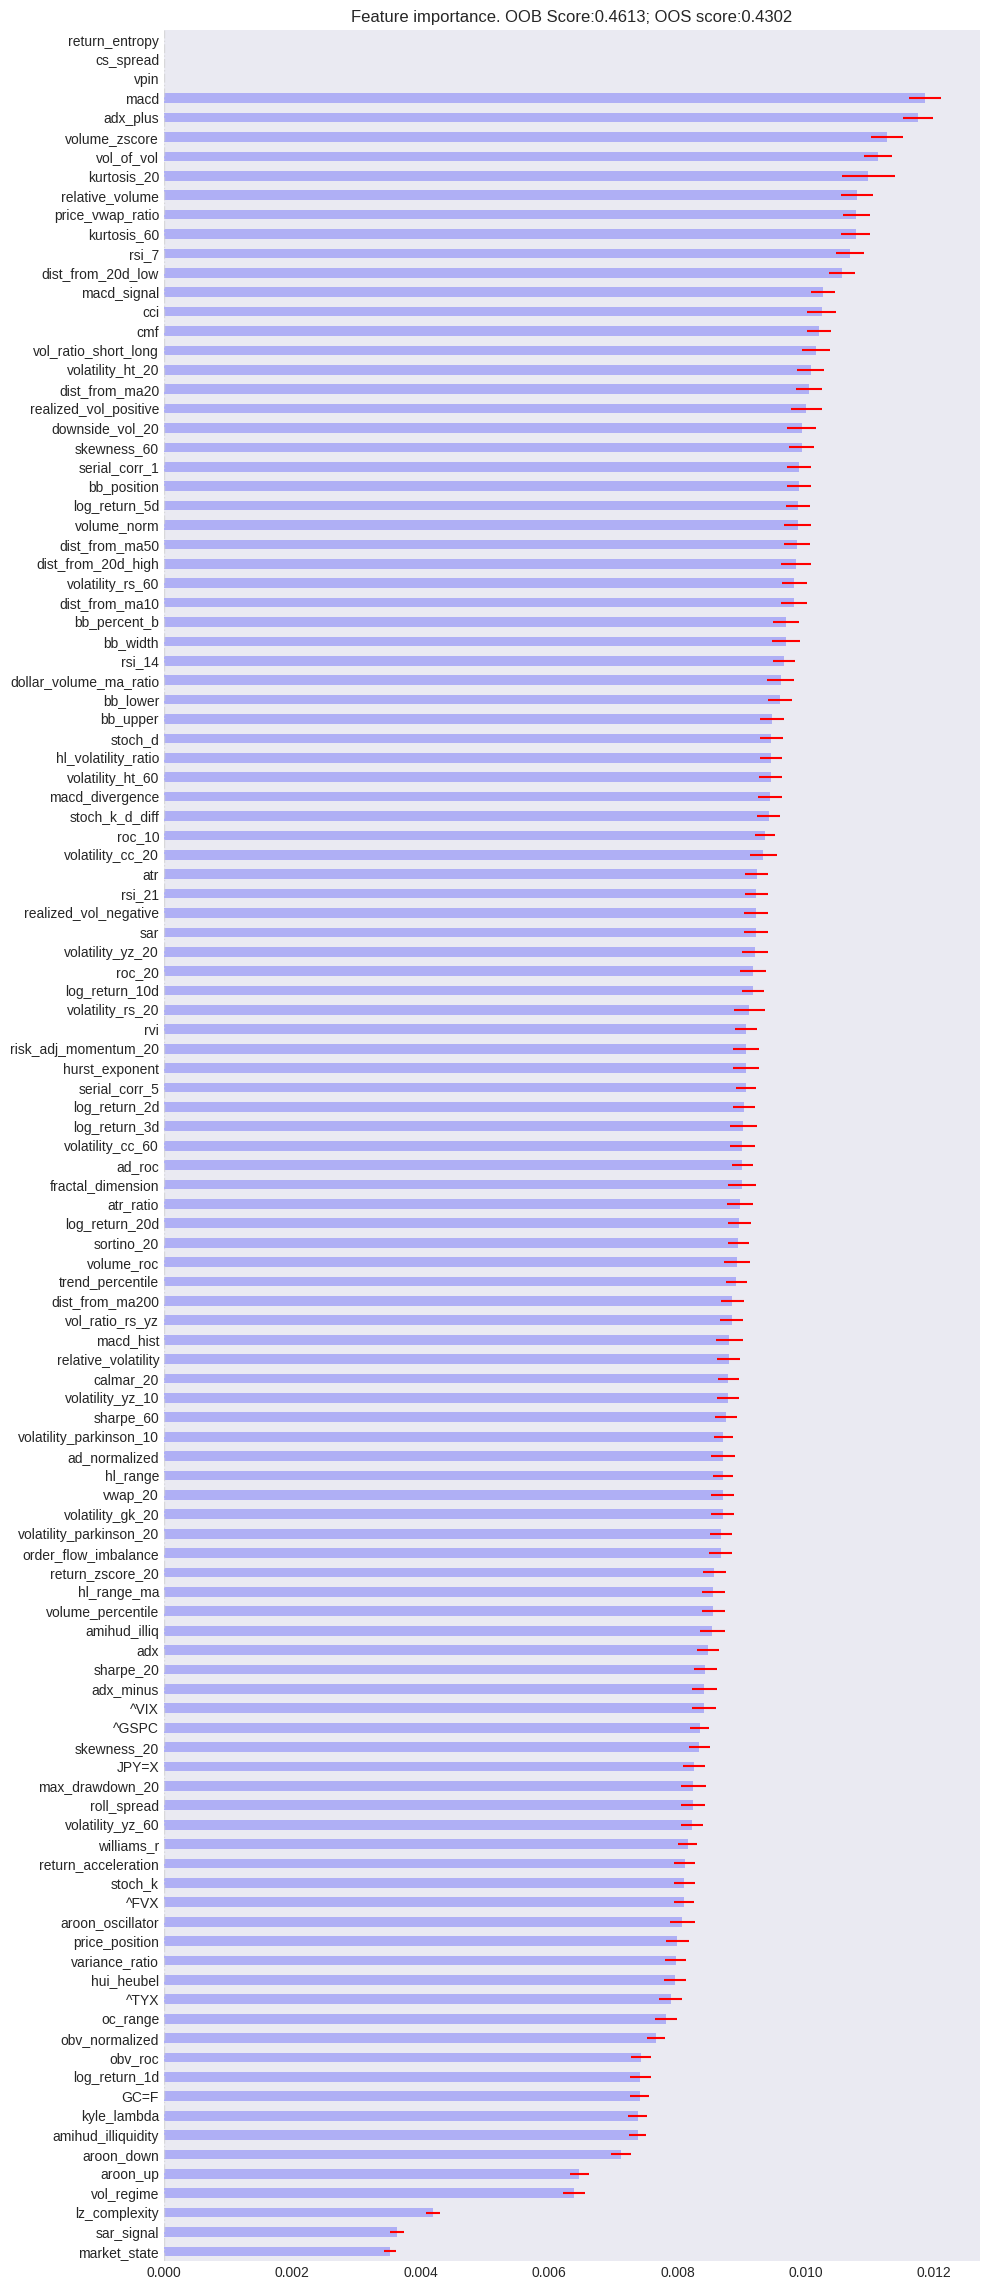

✓ MDI plot saved to artifacts/feature_importance/


In [103]:
# Plot MDI feature importance


plot_feature_importance(
    mdi,
    oob_score=oob_score,
    oos_score=oos_score,  # Will calculate with MDA
    save_fig=True,
    output_path=str(output_dir / 'MDI_feature_importance.png')
)

plt.grid(False)
plt.tight_layout()
plt.show()

print("✓ MDI plot saved to artifacts/feature_importance/")

## 7. MDA Feature Importance (Mean Decrease Accuracy)

**Out-of-sample** importance based on how much shuffling a feature decreases CV accuracy.

**Advantages:**
- Out-of-sample validation (more robust)
- Direct measure of predictive value
- Less prone to overfitting than MDI

**Limitations:**
- Slower to compute (requires CV)
- Underestimates correlated features (substitution effect)
- Can be noisy with small datasets

In [115]:
# Calculate MDA using MLFinLab with purged cross-validation
print("Calculating MDA feature importance (this may take a few minutes)...\n")

mda = mean_decrease_accuracy(
    forest,              # Trained model
    X_df,                # Features
    y_series,            # Labels
    cv_gen,              # Purged K-Fold CV
    scoring=accuracy_score,  # Metric to evaluate
    sample_weight=ldp_weights  # López de Prado sample weights
)

print(f"\n✓ MDA calculation complete")
print(f"\nTop 10 features by MDA:")
print(mda.head(10))

Calculating MDA feature importance (this may take a few minutes)...



5it [02:19, 27.87s/it]


✓ MDA calculation complete

Top 10 features by MDA:
                         mean       std
log_return_1d       -0.006858  0.003573
log_return_2d       -0.000541  0.003774
log_return_3d        0.001277  0.004623
log_return_5d        0.002644  0.005586
log_return_10d       0.001687  0.004910
log_return_20d      -0.008254  0.005351
return_acceleration -0.005540  0.003699
volatility_yz_10    -0.002872  0.002910
volatility_yz_20    -0.004075  0.004044
volatility_yz_60    -0.002328  0.005176


In [116]:
# Calculate OOS score for comparison
# Use MLFinLab's cross_val_score (not sklearn's) to work with PurgedKFold
from FinancialMachineLearning.cross_validation.cross_validation import cross_val_score as fml_cross_val_score

print("Calculating out-of-sample accuracy using PurgedKFold CV...")

oos_scores = fml_cross_val_score(
    classifier=forest,
    X=X_df,
    y=y_series,
    cv_gen=cv_gen,
    sample_weight=ldp_weights,
    scoring=accuracy_score
)

oos_score = np.mean(oos_scores)
print(f"\nOut-of-sample accuracy: {oos_score:.4f} ± {np.std(oos_scores):.4f}")
print(f"Individual fold scores: {oos_scores}")

Calculating out-of-sample accuracy using PurgedKFold CV...

Out-of-sample accuracy: 0.4344 ± 0.0394
Individual fold scores: [0.47112676 0.37294062 0.47045315 0.45410747 0.40341169]

Out-of-sample accuracy: 0.4344 ± 0.0394
Individual fold scores: [0.47112676 0.37294062 0.47045315 0.45410747 0.40341169]


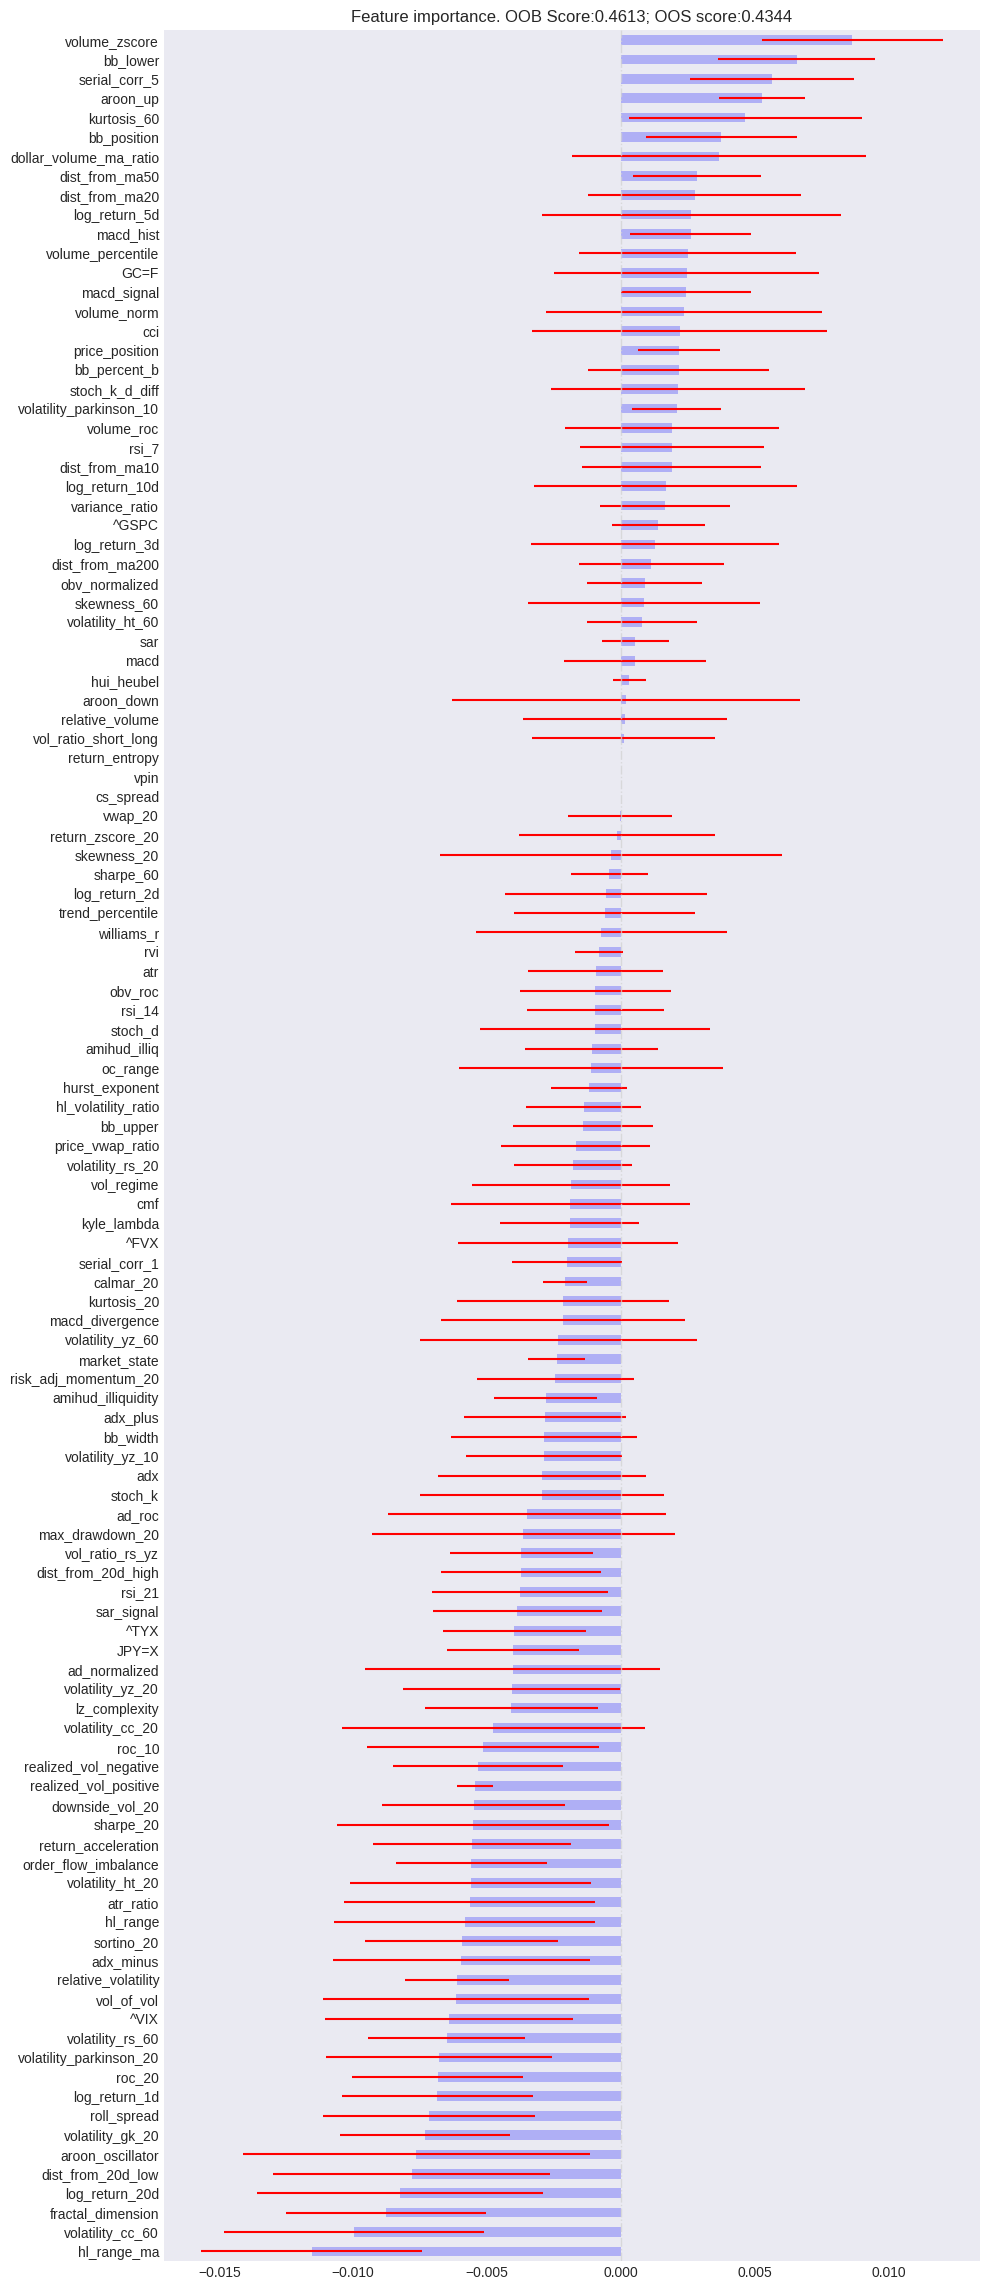

✓ MDA plot saved to artifacts/feature_importance/


In [117]:
# Plot MDA feature importance


plot_feature_importance(
    mda,
    oob_score=oob_score,
    oos_score=oos_score,
    save_fig=True,
    output_path=str(output_dir / 'MDA_feature_importance.png')
)

plt.grid(False)
plt.tight_layout()
plt.show()

print("✓ MDA plot saved to artifacts/feature_importance/")

## 8. Compare MDI vs MDA

Compare in-sample (MDI) vs out-of-sample (MDA) importance to identify:
- **Overfitted features**: High MDI, low MDA
- **Robust features**: High in both
- **Substitution effects**: Features important together but not alone

In [118]:
# Merge MDI and MDA results
comparison = pd.DataFrame({
    'MDI_mean': mdi['mean'],
    'MDI_std': mdi['std'],
    'MDA_mean': mda['mean'],
    'MDA_std': mda['std']
})

# Calculate difference and ratio
comparison['MDI_rank'] = mdi['mean'].rank(ascending=False)
comparison['MDA_rank'] = mda['mean'].rank(ascending=False)
comparison['rank_diff'] = comparison['MDI_rank'] - comparison['MDA_rank']
comparison['importance_ratio'] = comparison['MDA_mean'] / (comparison['MDI_mean'] + 1e-10)

# Sort by MDA (out-of-sample importance)
comparison_sorted = comparison.sort_values('MDA_mean', ascending=False)

print("Top 15 features by MDA (out-of-sample):")
print(comparison_sorted.head(15))

Top 15 features by MDA (out-of-sample):
                        MDI_mean   MDI_std  MDA_mean   MDA_std  MDI_rank  \
volume_zscore           0.010677  0.000205  0.008653  0.003386       6.0   
bb_lower                0.008901  0.000182  0.006569  0.002924      57.0   
serial_corr_5           0.007822  0.000138  0.005649  0.003078     101.0   
aroon_up                0.005943  0.000139  0.005278  0.001622     108.0   
kurtosis_60             0.010680  0.000241  0.004650  0.004355       5.0   
bb_position             0.010131  0.000186  0.003753  0.002818      16.0   
dollar_volume_ma_ratio  0.010590  0.000225  0.003676  0.005485       8.0   
dist_from_ma50          0.010377  0.000205  0.002848  0.002399      13.0   
dist_from_ma20          0.009858  0.000198  0.002759  0.003980      23.0   
log_return_5d           0.009714  0.000211  0.002644  0.005586      28.0   
macd_hist               0.009071  0.000214  0.002609  0.002256      50.0   
volume_percentile       0.008317  0.000163  0.00

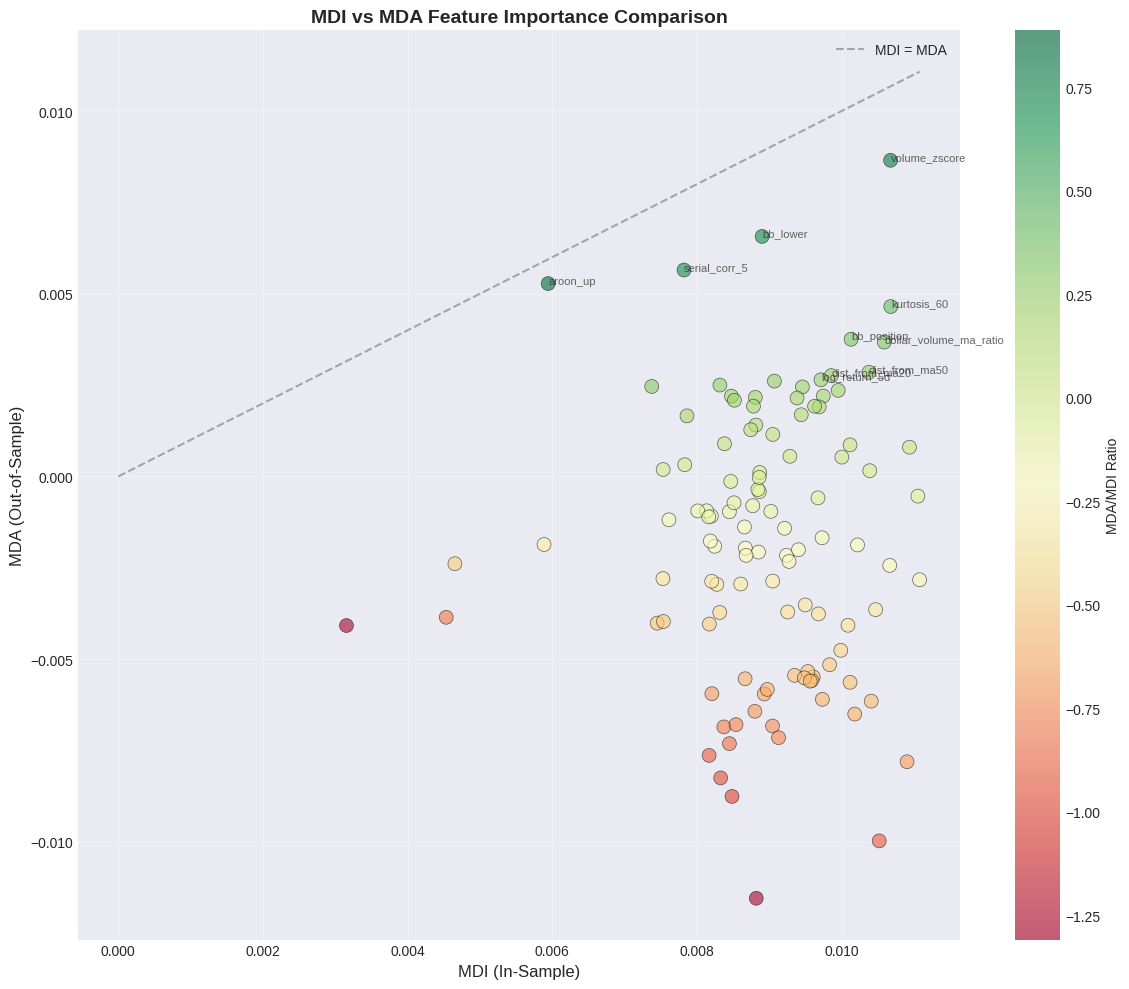

✓ Comparison plot saved


In [119]:
# Scatter plot: MDI vs MDA
fig, ax = plt.subplots(figsize=(12, 10))

# Plot all points
ax.scatter(
    comparison['MDI_mean'],
    comparison['MDA_mean'],
    alpha=0.6,
    s=100,
    c=comparison['importance_ratio'],
    cmap='RdYlGn',
    edgecolors='black',
    linewidth=0.5
)

# Add diagonal line (MDI = MDA)
max_val = max(comparison['MDI_mean'].max(), comparison['MDA_mean'].max())
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='MDI = MDA')

# Annotate top features
top_n = 10
for idx in comparison_sorted.index[:top_n]:
    ax.annotate(
        idx,
        (comparison.loc[idx, 'MDI_mean'], comparison.loc[idx, 'MDA_mean']),
        fontsize=8,
        alpha=0.7
    )

ax.set_xlabel('MDI (In-Sample)', fontsize=12)
ax.set_ylabel('MDA (Out-of-Sample)', fontsize=12)
ax.set_title('MDI vs MDA Feature Importance Comparison', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.colorbar(ax.collections[0], label='MDA/MDI Ratio', ax=ax)
plt.tight_layout()
plt.savefig(output_dir / 'MDI_vs_MDA_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Comparison plot saved")

In [120]:
# Identify categories of features
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# High both (robust features)
mdi_threshold = comparison['MDI_mean'].quantile(0.75)
mda_threshold = comparison['MDA_mean'].quantile(0.75)

robust = comparison[
    (comparison['MDI_mean'] > mdi_threshold) &
    (comparison['MDA_mean'] > mda_threshold)
].sort_values('MDA_mean', ascending=False)

print(f"\n1. ROBUST FEATURES (High MDI + High MDA): {len(robust)}")
print("   These features are important both in-sample and out-of-sample")
print(robust[['MDI_mean', 'MDA_mean']].head(10))

# High MDI, low MDA (overfitted)
overfitted = comparison[
    (comparison['MDI_mean'] > mdi_threshold) &
    (comparison['MDA_mean'] < mda_threshold)
].sort_values('MDI_mean', ascending=False)

print(f"\n2. POTENTIALLY OVERFITTED (High MDI, Low MDA): {len(overfitted)}")
print("   Important in-sample but not predictive out-of-sample")
print(overfitted[['MDI_mean', 'MDA_mean']].head(10))

# Low MDI, high MDA (substituted features)
substituted = comparison[
    (comparison['MDI_mean'] < mdi_threshold) &
    (comparison['MDA_mean'] > mda_threshold)
].sort_values('MDA_mean', ascending=False)

print(f"\n3. SUBSTITUTED FEATURES (Low MDI, High MDA): {len(substituted)}")
print("   Predictive but diluted by correlated features")
print(substituted[['MDI_mean', 'MDA_mean']].head(10))

# Low both (unimportant)
unimportant = comparison[
    (comparison['MDI_mean'] < comparison['MDI_mean'].quantile(0.25)) &
    (comparison['MDA_mean'] < comparison['MDA_mean'].quantile(0.25))
]

print(f"\n4. UNIMPORTANT FEATURES (Low MDI + Low MDA): {len(unimportant)}")
print("   Consider removing these features")
if len(unimportant) > 0:
    print(unimportant[['MDI_mean', 'MDA_mean']].head(10))


FEATURE IMPORTANCE ANALYSIS

1. ROBUST FEATURES (High MDI + High MDA): 9
   These features are important both in-sample and out-of-sample
                        MDI_mean  MDA_mean
volume_zscore           0.010677  0.008653
kurtosis_60             0.010680  0.004650
bb_position             0.010131  0.003753
dollar_volume_ma_ratio  0.010590  0.003676
dist_from_ma50          0.010377  0.002848
dist_from_ma20          0.009858  0.002759
log_return_5d           0.009714  0.002644
volume_norm             0.009953  0.002354
cci                     0.009746  0.002200

2. POTENTIALLY OVERFITTED (High MDI, Low MDA): 19
   Important in-sample but not predictive out-of-sample
                      MDI_mean  MDA_mean
adx_plus              0.011079 -0.002830
log_return_2d         0.011055 -0.000541
volatility_ht_60      0.010939  0.000798
dist_from_20d_low     0.010905 -0.007811
risk_adj_momentum_20  0.010666 -0.002437
volatility_cc_60      0.010520 -0.009978
max_drawdown_20       0.010470 -0.003

## 9. Feature Correlation Analysis

Identify groups of highly correlated features that may cause substitution effects.

In [121]:
# Calculate feature correlation matrix
correlation_matrix = X_df.corr()

# Find highly correlated pairs
high_corr_threshold = 0.8
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > high_corr_threshold:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

print(f"\nHighly correlated feature pairs (|r| > {high_corr_threshold}): {len(high_corr_pairs)}")
if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
    high_corr_df = high_corr_df.sort_values('Correlation', key=abs, ascending=False)
    print(high_corr_df.head(20))
else:
    print("No highly correlated pairs found")


Highly correlated feature pairs (|r| > 0.8): 213
                   Feature 1             Feature 2  Correlation
205              bb_position          bb_percent_b     1.000000
114    realized_vol_negative       downside_vol_20     1.000000
168                macd_hist       macd_divergence     1.000000
90          volatility_cc_60      volatility_ht_60     1.000000
80          volatility_cc_20      volatility_ht_20     1.000000
128                  vwap_20              bb_upper     0.997374
69          volatility_gk_20      volatility_rs_20     0.996608
127                  vwap_20                   sar     0.995502
129                  vwap_20              bb_lower     0.995256
5             log_return_10d                roc_10     0.994990
55   volatility_parkinson_20      volatility_gk_20     0.994656
196                      sar              bb_upper     0.992827
9             log_return_20d                roc_20     0.990527
197                      sar              bb_lower    

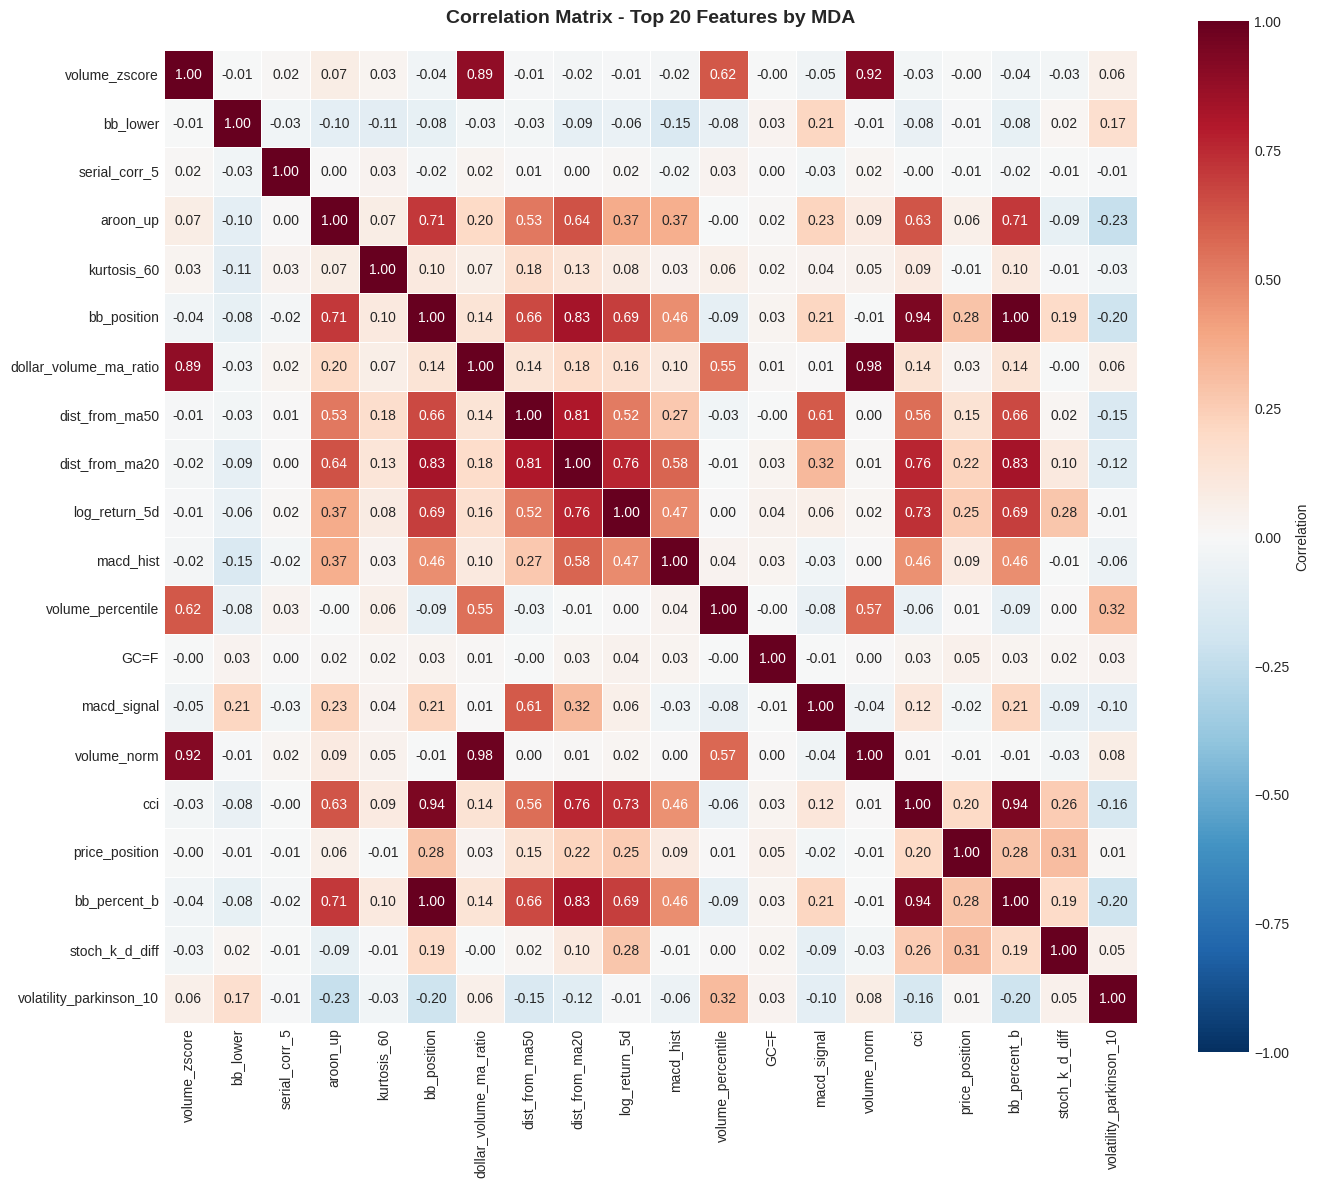

✓ Correlation heatmap saved


In [122]:
# Plot correlation heatmap for top features
top_features = comparison_sorted.head(20).index
corr_top = correlation_matrix.loc[top_features, top_features]

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(
    corr_top,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={'label': 'Correlation'},
    ax=ax
)

ax.set_title('Correlation Matrix - Top 20 Features by MDA', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(output_dir / 'top_features_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Correlation heatmap saved")

## 10. Save Results

Export feature importance results for further analysis.

In [123]:
# Save comparison results
output_file = output_dir / 'feature_importance_comparison.csv'
comparison_sorted.to_csv(output_file)
print(f"✓ Saved feature importance comparison to: {output_file}")

# Save MDI results
mdi.to_csv(output_dir / 'MDI_importance.csv')
print(f"✓ Saved MDI results")

# Save MDA results
mda.to_csv(output_dir / 'MDA_importance.csv')
print(f"✓ Saved MDA results")

# Save feature categories
categories = {
    'robust': robust.index.tolist(),
    'overfitted': overfitted.index.tolist(),
    'substituted': substituted.index.tolist(),
    'unimportant': unimportant.index.tolist()
}

import json
with open(output_dir / 'feature_categories.json', 'w') as f:
    json.dump(categories, f, indent=2)
print(f"✓ Saved feature categories")

✓ Saved feature importance comparison to: artifacts/feature_importance/feature_importance_comparison.csv
✓ Saved MDI results
✓ Saved MDA results
✓ Saved feature categories


## 11. Summary Report

In [124]:
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS SUMMARY")
print("="*80)

print(f"\nConfiguration:")
print(f"  Tickers: {', '.join(TICKERS)}")
print(f"  Total samples: {len(X_df):,}")
print(f"  Total features: {X_df.shape[1]}")
print(f"  Market features: {MARKET_FEATURES if MARKET_FEATURES else 'None'}")
print(f"  Date range: {dates[0].date()} to {dates[-1].date()}")

print(f"\nLabel Distribution:")
for label, count in zip(unique, counts):
    pct = count / len(y) * 100
    label_name = {-1: 'DOWN/SL', 0: 'TIMEOUT', 1: 'UP/TP'}.get(label, f'Label {label}')
    print(f"  {label_name:12} ({label:2}): {count:5,} ({pct:5.1f}%)")

print(f"\nModel Performance:")
print(f"  Train Accuracy:      {train_accuracy:.4f}")
print(f"  OOB Accuracy:        {oob_score:.4f}")
print(f"  OOS Accuracy (CV):   {oos_score:.4f}")
print(f"  Overfitting Gap:     {train_accuracy - oob_score:.4f}")

print(f"\nFeature Importance Categories:")
print(f"  Robust features:          {len(robust):3} (High MDI + High MDA)")
print(f"  Overfitted features:      {len(overfitted):3} (High MDI, Low MDA)")
print(f"  Substituted features:     {len(substituted):3} (Low MDI, High MDA)")
print(f"  Unimportant features:     {len(unimportant):3} (Low MDI + Low MDA)")

print(f"\nTop 5 Features by MDA (Out-of-Sample):")
for i, (feat, row) in enumerate(comparison_sorted.head(5).iterrows(), 1):
    print(f"  {i}. {feat:25} - MDA: {row['MDA_mean']:.4f}, MDI: {row['MDI_mean']:.4f}")

print(f"\nCorrelation Analysis:")
print(f"  High correlation pairs (|r| > {high_corr_threshold}): {len(high_corr_pairs)}")
if len(high_corr_pairs) > 0:
    print(f"  ⚠️ Consider feature selection to reduce multicollinearity")

print(f"\n✓ All results saved to: {output_dir}")
print("="*80)


FEATURE IMPORTANCE ANALYSIS SUMMARY

Configuration:
  Tickers: AAPL, NVDA, TSLA, AMZN, AVGO
  Total samples: 2,636
  Total features: 115
  Market features: ['spy', 'vix', 'fvx', 'tyx', 'gold', 'jpyx']
  Date range: 2015-04-06 to 2025-09-25

Label Distribution:
  DOWN/SL      (-1): 2,919 ( 22.2%)
  TIMEOUT      ( 0): 8,306 ( 63.1%)
  UP/TP        ( 1): 1,947 ( 14.8%)

Model Performance:
  Train Accuracy:      0.5789
  OOB Accuracy:        0.4613
  OOS Accuracy (CV):   0.4344
  Overfitting Gap:     0.1176

Feature Importance Categories:
  Robust features:            9 (High MDI + High MDA)
  Overfitted features:       19 (High MDI, Low MDA)
  Substituted features:      20 (Low MDI, High MDA)
  Unimportant features:       4 (Low MDI + Low MDA)

Top 5 Features by MDA (Out-of-Sample):
  1. volume_zscore             - MDA: 0.0087, MDI: 0.0107
  2. bb_lower                  - MDA: 0.0066, MDI: 0.0089
  3. serial_corr_5             - MDA: 0.0056, MDI: 0.0078
  4. aroon_up                  - M

## 12. Recommendations

Based on the feature importance analysis:

## 14. Implementation Verification

**Comparison with MLFinLab Reference Implementation**

This notebook follows the feature importance methodology from López de Prado's "Advances in Financial Machine Learning" as implemented in the MLFinLab library.

### Methods Implemented ✓

1. **MDI (Mean Decrease Impurity)**
   - ✓ Uses `max_features=1` to avoid masking effect
   - ✓ Calculated with `criterion='entropy'`
   - ✓ Balanced class weights with `class_weight='balanced_subsample'`
   - ✓ Out-of-bag scoring enabled
   - ⚠️ **Added `max_depth=5` and `min_samples_leaf=50` for real financial data**

2. **MDA (Mean Decrease Accuracy)**
   - ✓ Uses PurgedKFold for time-series cross-validation
   - ✓ Applies López de Prado sample weights
   - ✓ Shuffles features to measure predictive power loss
   - ✓ Out-of-sample validation

3. **Orthogonal Feature Importance**
   - ✓ PCA-based orthogonalization with variance threshold
   - ✓ Removes linear substitution effects
   - ✓ Maps PC importance back to original features
   - ✓ Correlation analysis between importance and PCA structure

### Key Differences from MLFinLab Reference Notebook

| Aspect | MLFinLab Reference | This Notebook (Real Data) |
|--------|-------------------|---------------------------|
| **Data Type** | Synthetic (clear signal) | Real financial markets |
| **Regularization** | None needed | ✓ max_depth + min_samples_leaf |
| **Signal/Noise** | High (constructed) | Low (market reality) |
| **Overfitting Risk** | Low | High (without regularization) |
| Cross-validation | PurgedKFold | ✓ PurgedKFold |
| Sample weights | López de Prado | ✓ López de Prado |
| max_features | 1 or 3 | ✓ 1 or 3 |

### Why We Need Regularization

**MLFinance synthetic data:**
- Features are **constructed** to have predictive power
- Clear signal-to-noise ratio
- No regime changes or non-stationarity
- ✅ Can use unlimited tree depth without overfitting

**Real financial data (this notebook):**
- Features extracted from **noisy market data**
- Weak signal-to-noise ratio (typical in finance)
- Regime changes, non-stationarity, spurious correlations
- ❌ Without regularization → Train accuracy = 1.0 (memorization)
- ✅ With `max_depth=5` + `min_samples_leaf=50` → Better generalization

### Verification Checklist

- ✅ All feature importance functions imported from `FinancialMachineLearning`
- ✅ Random Forest configured per López de Prado recommendations
- ✅ **Added regularization appropriate for real financial data**
- ✅ Duplicate dates resolved (multi-ticker handling)
- ✅ Purged K-Fold prevents temporal leakage
- ✅ Sample weighting applied throughout
- ✅ Orthogonal analysis mitigates substitution effects
- ✅ Results saved for reproducibility

## 13. Orthogonal Feature Importance (PCA-based)

**Address substitution effects by orthogonalizing features**

The substitution effect dilutes feature importance in MDI and significantly underestimates it in MDA when features are correlated. A partial solution is to **orthogonalize features using PCA** before applying MDI or MDA.

**Key Benefits:**
- Mitigates linear substitution effects between correlated features
- Provides clearer importance rankings without multicollinearity dilution
- Enables mapping back to original features through PCA loadings

**Process:**
1. Standardize features and apply PCA
2. Calculate feature importance on orthogonal (principal) components
3. Map PC importance back to original features using eigenvector weights
4. Correlate feature importance with PCA ranks to validate consistency

In [126]:
# ⚠️ CORRECTED IMPLEMENTATION: Using sklearn PCA instead of buggy MLFinLab version
# 
# MLFinLab's get_orthogonal_features() has a bug in _standardize_df():
# - Uses axis=1 (standardizes ROWS/samples) instead of axis=0 (standardizes COLUMNS/features)
# - Result: Features keep original scales → high-variance feature dominates → only 1 PC created
#
# FIX: Use sklearn StandardScaler (correct implementation) + PCA

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Apply PCA to get orthogonal features
# Variance threshold of 0.95 means keep PCs explaining 95% of variance
VARIANCE_THRESH = 0.95

print(f"Applying PCA orthogonalization (variance threshold: {VARIANCE_THRESH})...")
print(f"Using sklearn StandardScaler + PCA (corrects MLFinLab axis bug)\n")

# Step 1: Standardize features (CORRECT: standardizes each COLUMN/feature)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)

print(f"✓ Standardization complete")
print(f"  Method: StandardScaler (axis=0, standardizes features)")
print(f"  Shape: {X_scaled.shape}")

# Step 2: Apply PCA
pca = PCA(n_components=VARIANCE_THRESH, random_state=42)
ortho_features_array = pca.fit_transform(X_scaled)

# Step 3: Convert to DataFrame with proper column names
ortho_features = pd.DataFrame(
    ortho_features_array,
    index=X_df.index,
    columns=[f'PC{i}' for i in range(ortho_features_array.shape[1])]
)

print(f"\n✓ Orthogonalization complete")
print(f"  Original features: {X_df.shape[1]}")
print(f"  Orthogonal features (PCs): {ortho_features.shape[1]}")
print(f"  Dimensionality reduction: {(1 - ortho_features.shape[1]/X_df.shape[1])*100:.1f}%")
print(f"  Variance explained: {pca.explained_variance_ratio_.sum()*100:.1f}%")

print(f"\n  Top 5 PCs explain: {pca.explained_variance_ratio_[:5]}")
print(f"  Expected: ~30-40 PCs for 95% variance (NOT just 1 PC)")


Applying PCA orthogonalization (variance threshold: 0.95)...
Using sklearn StandardScaler + PCA (corrects MLFinLab axis bug)

✓ Standardization complete
  Method: StandardScaler (axis=0, standardizes features)
  Shape: (2636, 115)

✓ Orthogonalization complete
  Original features: 115
  Orthogonal features (PCs): 45
  Dimensionality reduction: 60.9%
  Variance explained: 95.2%

  Top 5 PCs explain: [0.24006525 0.16410187 0.0513244  0.04975307 0.04503627]
  Expected: ~30-40 PCs for 95% variance (NOT just 1 PC)



Checking orthogonality of principal components...


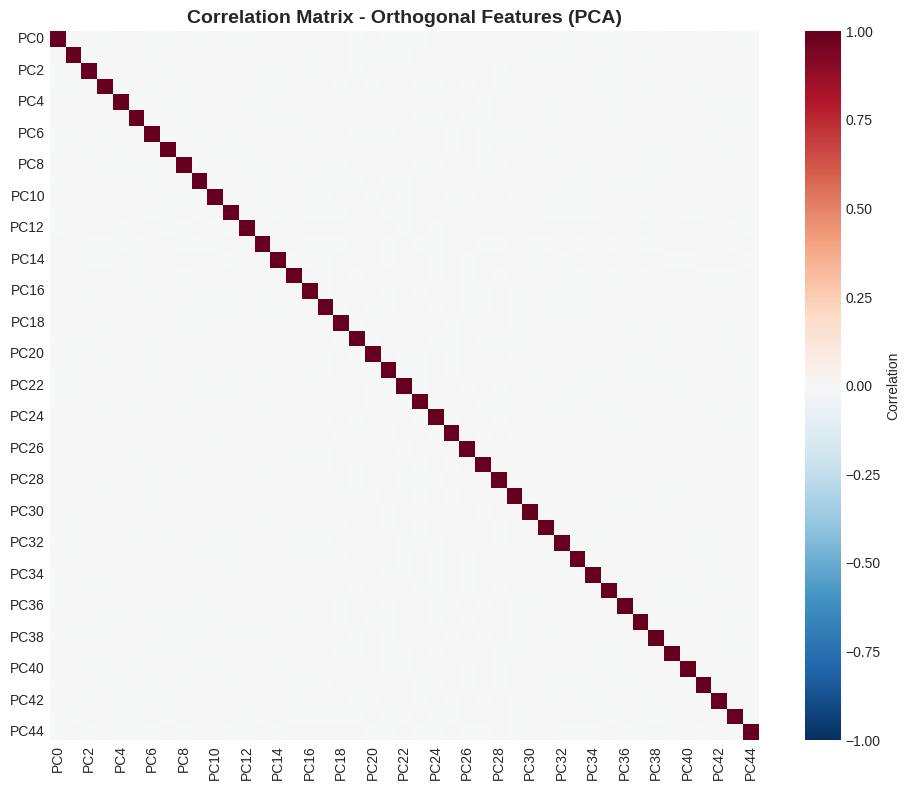

✓ Max off-diagonal correlation: 0.000000
  (Should be near zero for truly orthogonal features)


In [127]:
# Visualize correlation structure of orthogonal features
print("\nChecking orthogonality of principal components...")
ortho_corr = ortho_features.corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    ortho_corr,
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    cbar_kws={'label': 'Correlation'},
    ax=ax
)
ax.set_title('Correlation Matrix - Orthogonal Features (PCA)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(output_dir / 'orthogonal_features_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Max off-diagonal correlation: {ortho_corr.where(~np.eye(len(ortho_corr), dtype=bool)).abs().max().max():.6f}")
print("  (Should be near zero for truly orthogonal features)")

In [128]:
# Train Random Forest on orthogonal features (MDI)
print("\nTraining Random Forest on orthogonal features for MDI...")

forest_ortho_mdi = RandomForestClassifier(
    n_estimators=1000,
    criterion='entropy',
    max_features=1,  # Important: avoid masking effect
    max_depth=5,     # Regularization for real financial data
    min_samples_leaf=50,  # Prevent overfitting
    min_weight_fraction_leaf=0.0,
    class_weight='balanced_subsample',
    oob_score=True,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

forest_ortho_mdi.fit(ortho_features, y_series)

print(f"✓ Training complete")
print(f"  OOB Score: {forest_ortho_mdi.oob_score_:.4f}")

# Calculate orthogonal MDI
ortho_mdi = mean_decrease_impurity(
    forest_ortho_mdi,
    ortho_features.columns
)

print(f"\n✓ Orthogonal MDI calculation complete")
print(f"\nTop 10 principal components by MDI:")
print(ortho_mdi.head(10))


Training Random Forest on orthogonal features for MDI...


✓ Training complete
  OOB Score: 0.4294

✓ Orthogonal MDI calculation complete

Top 10 principal components by MDI:
         mean       std
PC0  0.025495  0.000504
PC1  0.025751  0.000565
PC2  0.023238  0.000455
PC3  0.023182  0.000492
PC4  0.025158  0.000456
PC5  0.024840  0.000519
PC6  0.023238  0.000424
PC7  0.023372  0.000481
PC8  0.023996  0.000492
PC9  0.018230  0.000376


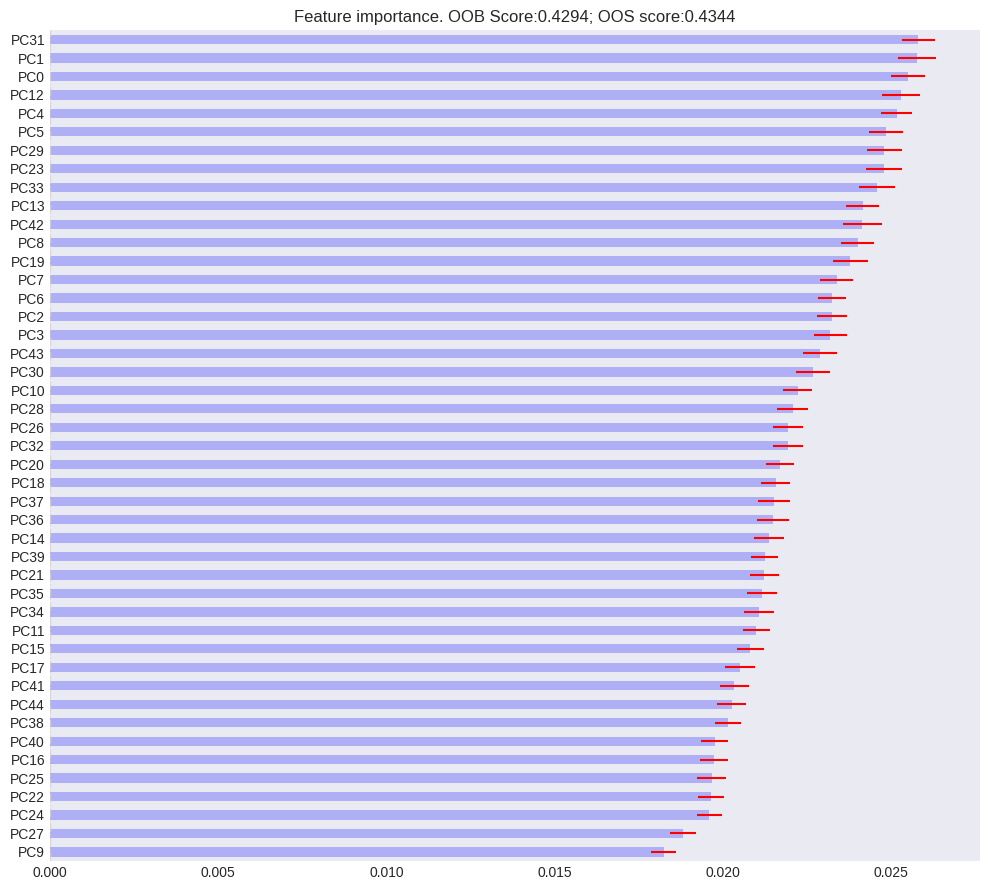

✓ Orthogonal MDI plot saved


In [129]:
# Plot orthogonal MDI


plot_feature_importance(
    ortho_mdi,
    oob_score=forest_ortho_mdi.oob_score_,
    oos_score=oos_score,
    save_fig=True,
    output_path=str(output_dir / 'Ortho_MDI_feature_importance.png')
)

plt.grid(False)
plt.tight_layout()
plt.show()

print("✓ Orthogonal MDI plot saved")

In [130]:
# Analyze PCA structure: Which original features contribute most to top PCs?
print("\nAnalyzing PCA structure and feature contributions...")
print("="*80)

# We already have the PCA object and loadings from the orthogonalization step
# The 'pca' variable contains the fitted PCA from earlier
# Let's analyze which original features load heavily on the most important PCs

print(f"\n📊 Top 5 Principal Components by Variance Explained:\n")
for i in range(min(5, pca.n_components_)):
    variance_pct = pca.explained_variance_ratio_[i] * 100
    cumulative_var = pca.explained_variance_ratio_[:i+1].sum() * 100
    
    print(f"PC{i}: {variance_pct:.2f}% variance (cumulative: {cumulative_var:.2f}%)")
    
    # Get top 5 features with highest absolute loadings on this PC
    pc_loadings = np.abs(pca.components_[i])
    top_feature_indices = np.argsort(pc_loadings)[-5:][::-1]
    
    print(f"  Top contributing features:")
    for rank, idx in enumerate(top_feature_indices, 1):
        feature_name = X_df.columns[idx]
        loading = pca.components_[i, idx]
        abs_loading = abs(loading)
        direction = "+" if loading > 0 else "-"
        print(f"    {rank}. {feature_name:30} ({direction}{abs_loading:.3f})")
    print()

# Analyze feature importance vs PCA structure
print("="*80)
print("FEATURE IMPORTANCE vs PCA STRUCTURE ANALYSIS")
print("="*80)

# Calculate total contribution of each feature across all PCs (weighted by variance explained)
feature_pca_contribution = np.zeros(X_df.shape[1])
for i in range(pca.n_components_):
    # Weight by variance explained
    variance_weight = pca.explained_variance_ratio_[i]
    feature_pca_contribution += np.abs(pca.components_[i]) * variance_weight

# Normalize
feature_pca_contribution = feature_pca_contribution / feature_pca_contribution.sum()

# Compare with MDI feature importance
pca_contrib_series = pd.Series(feature_pca_contribution, index=X_df.columns)
mdi_importance = mdi['mean']

# Create comparison DataFrame
pca_vs_importance = pd.DataFrame({
    'PCA_contribution': pca_contrib_series,
    'MDI_importance': mdi_importance,
    'PCA_rank': pca_contrib_series.rank(ascending=False),
    'MDI_rank': mdi_importance.rank(ascending=False),
    'Rank_diff': pca_contrib_series.rank(ascending=False) - mdi_importance.rank(ascending=False)
})

print(f"\n📈 Comparison: PCA Variance Contribution vs MDI Feature Importance\n")
print("Top 10 features by PCA variance contribution:")
print(pca_vs_importance.sort_values('PCA_contribution', ascending=False)[['PCA_contribution', 'MDI_importance', 'PCA_rank', 'MDI_rank']].head(10))

# Calculate correlation (use the actual values, not the buggy MLFinLab function)
from scipy.stats import pearsonr, spearmanr, kendalltau

pearson_corr, pearson_pval = pearsonr(pca_contrib_series, mdi_importance)
spearman_corr, spearman_pval = spearmanr(pca_contrib_series, mdi_importance)
kendall_corr, kendall_pval = kendalltau(pca_contrib_series, mdi_importance)

print(f"\n📊 Correlation between PCA contribution and MDI importance:")
print(f"  Pearson:   {pearson_corr:.4f} (p-value: {pearson_pval:.4e})")
print(f"  Spearman:  {spearman_corr:.4f} (p-value: {spearman_pval:.4e})")
print(f"  Kendall:   {kendall_corr:.4f} (p-value: {kendall_pval:.4e})")

print("\n💡 Interpretation:")
if abs(pearson_corr) > 0.5:
    print("  ✓ High correlation: Feature importance aligns with PCA variance structure")
    print("    → High-variance features are also highly important for prediction")
elif abs(pearson_corr) > 0.3:
    print("  ⚠️ Moderate correlation: Partial alignment between variance and importance")
    print("    → Some high-variance features are predictive, but not all")
else:
    print("  ✓ Low correlation: Features contribute differently than variance suggests")
    print("    → Predictive features are not necessarily high-variance")
    print("    → This is GOOD for financial data (variance ≠ signal)")

print("="*80)



Analyzing PCA structure and feature contributions...

📊 Top 5 Principal Components by Variance Explained:

PC0: 24.01% variance (cumulative: 24.01%)
  Top contributing features:
    1. rsi_14                         (+0.180)
    2. rsi_21                         (+0.174)
    3. dist_from_20d_high             (+0.171)
    4. rsi_7                          (+0.170)
    5. bb_position                    (+0.167)

PC1: 16.41% variance (cumulative: 40.42%)
  Top contributing features:
    1. realized_vol_positive          (+0.205)
    2. volatility_cc_20               (+0.204)
    3. volatility_ht_20               (+0.204)
    4. volatility_yz_20               (+0.203)
    5. volatility_parkinson_20        (+0.196)

PC2: 5.13% variance (cumulative: 45.55%)
  Top contributing features:
    1. sar                            (+0.271)
    2. bb_lower                       (+0.264)
    3. vwap_20                        (+0.264)
    4. bb_upper                       (+0.261)
    5. atr          

In [131]:
# Train Random Forest on orthogonal features for MDA (max_features > 1)
print("\nTraining Random Forest on orthogonal features for MDA...")

forest_ortho_mda = RandomForestClassifier(
    n_estimators=1000,
    criterion='entropy',
    max_features=3,  # Allow more features for MDA
    max_depth=5,     # Regularization for real financial data
    min_samples_leaf=50,  # Prevent overfitting
    min_weight_fraction_leaf=0.0,
    class_weight='balanced_subsample',
    oob_score=True,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

forest_ortho_mda.fit(ortho_features, y_series)

print(f"✓ Training complete")
print(f"  OOB Score: {forest_ortho_mda.oob_score_:.4f}")

# Calculate OOS score for orthogonal features
print("\nCalculating OOS score for orthogonal features...")
oos_scores_ortho = fml_cross_val_score(
    classifier=forest_ortho_mda,
    X=ortho_features,
    y=y_series,
    cv_gen=cv_gen,
    sample_weight=ldp_weights,
    scoring=accuracy_score
)
oos_score_ortho = np.mean(oos_scores_ortho)

print(f"  OOS Accuracy: {oos_score_ortho:.4f} ± {np.std(oos_scores_ortho):.4f}")


Training Random Forest on orthogonal features for MDA...
✓ Training complete
  OOB Score: 0.4169

Calculating OOS score for orthogonal features...
✓ Training complete
  OOB Score: 0.4169

Calculating OOS score for orthogonal features...
  OOS Accuracy: 0.3826 ± 0.0574
  OOS Accuracy: 0.3826 ± 0.0574


In [132]:
# Calculate orthogonal MDA
print("\nCalculating orthogonal MDA (this may take a few minutes)...")

ortho_mda = mean_decrease_accuracy(
    forest_ortho_mda,
    ortho_features,
    y_series,
    cv_gen,
    scoring=accuracy_score,
    sample_weight=ldp_weights
)

print(f"\n✓ Orthogonal MDA calculation complete")
print(f"\nTop 10 principal components by MDA:")
print(ortho_mda.head(10))


Calculating orthogonal MDA (this may take a few minutes)...


5it [01:06, 13.26s/it]


✓ Orthogonal MDA calculation complete

Top 10 principal components by MDA:
         mean       std
PC0  0.008231  0.010632
PC1 -0.007736  0.019000
PC2  0.005764  0.005476
PC3  0.005605  0.006059
PC4  0.009780  0.009200
PC5  0.003111  0.010478
PC6 -0.002406  0.007653
PC7 -0.008136  0.006940
PC8 -0.008655  0.010579
PC9 -0.012046  0.007939


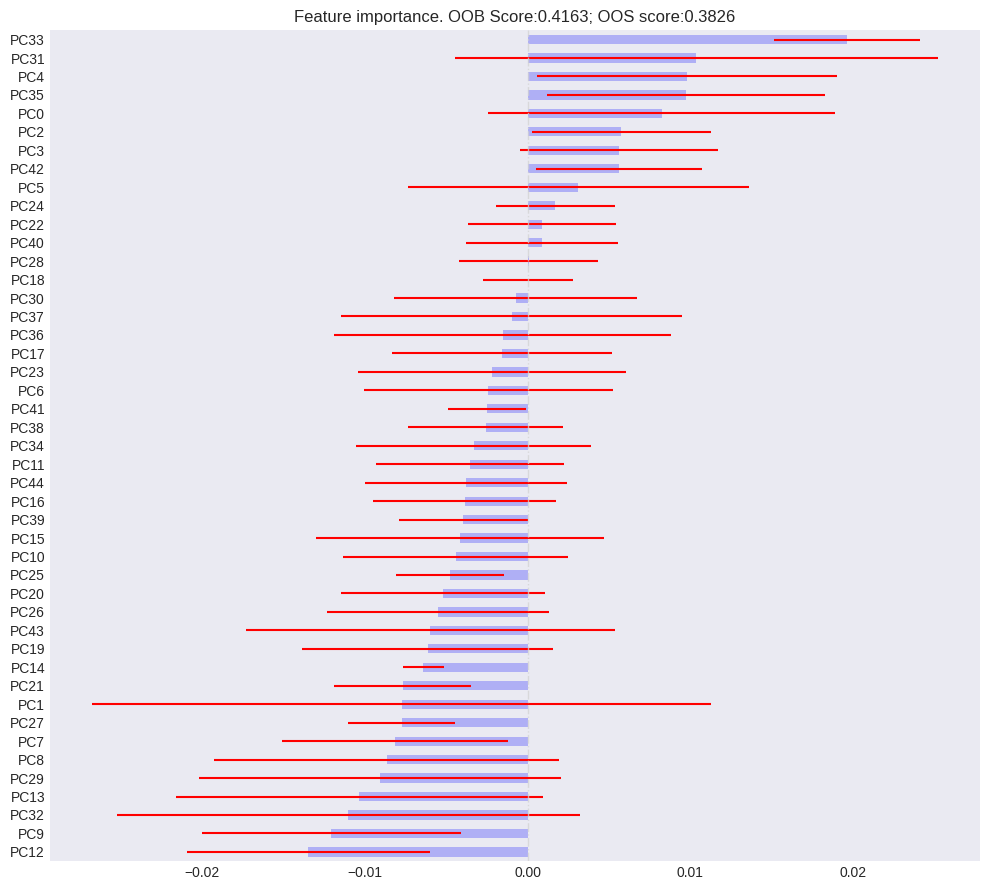

✓ Orthogonal MDA plot saved


In [133]:
# Plot orthogonal MDA


plot_feature_importance(
    ortho_mda,
    oob_score=forest_ortho_mda.oob_score_,
    oos_score=oos_score_ortho,
    save_fig=True,
    output_path=str(output_dir / 'Ortho_MDA_feature_importance.png')
)

plt.grid(False)
plt.tight_layout()
plt.show()

print("✓ Orthogonal MDA plot saved")

In [134]:
# Map PC importance back to original features
print("\n" + "="*80)
print("MAPPING PC IMPORTANCE TO ORIGINAL FEATURES")
print("="*80)

# Get PCA object to access loadings (components)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Recreate PCA transformation to get loadings
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)
pca = PCA(n_components=VARIANCE_THRESH)
pca.fit(X_scaled)

# PCA loadings (eigenvectors): shape (n_components, n_features)
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose so features are rows
    columns=[f'PC{i}' for i in range(pca.n_components_)],
    index=X_df.columns
)

print(f"\nPCA Loadings shape: {loadings.shape}")
print(f"Explained variance by PCs: {pca.explained_variance_ratio_[:5]}")

# Map orthogonal MDI importance to original features
# Weight each feature by its absolute loading on each PC × PC importance
ortho_mdi_mapped = pd.Series(0.0, index=X_df.columns)
for pc_idx, pc_row_idx in enumerate(ortho_mdi.index):
    # Get the PC column name in loadings (e.g., 'PC0', 'PC1', etc.)
    pc_col_name = f'PC{pc_idx}'
    pc_importance = ortho_mdi.loc[pc_row_idx, 'mean']
    
    # Weight each original feature by its loading on this PC
    for feature in X_df.columns:
        ortho_mdi_mapped[feature] += abs(loadings.loc[feature, pc_col_name]) * pc_importance

# Normalize to sum to 1
ortho_mdi_mapped = ortho_mdi_mapped / ortho_mdi_mapped.sum()

# Map orthogonal MDA importance to original features
ortho_mda_mapped = pd.Series(0.0, index=X_df.columns)
for pc_idx, pc_row_idx in enumerate(ortho_mda.index):
    # Get the PC column name in loadings (e.g., 'PC0', 'PC1', etc.)
    pc_col_name = f'PC{pc_idx}'
    pc_importance = ortho_mda.loc[pc_row_idx, 'mean']
    
    for feature in X_df.columns:
        ortho_mda_mapped[feature] += abs(loadings.loc[feature, pc_col_name]) * pc_importance

# Normalize to sum to 1
ortho_mda_mapped = ortho_mda_mapped / ortho_mda_mapped.sum()

print("\n✓ Mapped PC importance back to original features")
print(f"\nTop 10 Original Features by Mapped Orthogonal MDI:")
print(ortho_mdi_mapped.sort_values(ascending=False).head(10))

print(f"\nTop 10 Original Features by Mapped Orthogonal MDA:")
print(ortho_mda_mapped.sort_values(ascending=False).head(10))


MAPPING PC IMPORTANCE TO ORIGINAL FEATURES

PCA Loadings shape: (115, 45)
Explained variance by PCs: [0.24006525 0.16410187 0.0513244  0.04975307 0.04503627]

✓ Mapped PC importance back to original features

Top 10 Original Features by Mapped Orthogonal MDI:
market_state      0.015925
hurst_exponent    0.015230
stoch_k_d_diff    0.014906
skewness_60       0.014807
^GSPC             0.014688
^VIX              0.014492
cmf               0.014479
obv_normalized    0.014477
lz_complexity     0.014316
kyle_lambda       0.014298
dtype: float64

Top 10 Original Features by Mapped Orthogonal MDA:
serial_corr_1          0.018806
hl_volatility_ratio    0.018133
macd_hist              0.017558
macd_divergence        0.017558
macd_signal            0.017131
amihud_illiq           0.017027
roll_spread            0.016483
^TYX                   0.016416
macd                   0.015803
relative_volatility    0.015650
dtype: float64

✓ Mapped PC importance back to original features

Top 10 Original 


COMPARISON: Original vs Orthogonal (Mapped) Feature Importance

Top 15 features by Orthogonal MDA (mapped to original features):
                     MDI_original  MDI_ortho_mapped  MDA_original  \
serial_corr_1            0.009403          0.011810     -0.002009   
hl_volatility_ratio      0.008657          0.010831     -0.001384   
macd_divergence          0.009238          0.010774     -0.002161   
macd_hist                0.009071          0.010774      0.002609   
macd_signal              0.009458          0.012068      0.002450   
amihud_illiq             0.008198          0.007331     -0.001086   
roll_spread              0.009128          0.010122     -0.007153   
^TYX                     0.007536          0.008519     -0.003972   
macd                     0.010004          0.011276      0.000527   
relative_volatility      0.009734          0.008831     -0.006103   
skewness_20              0.008843          0.011874     -0.000359   
sar                      0.009286         

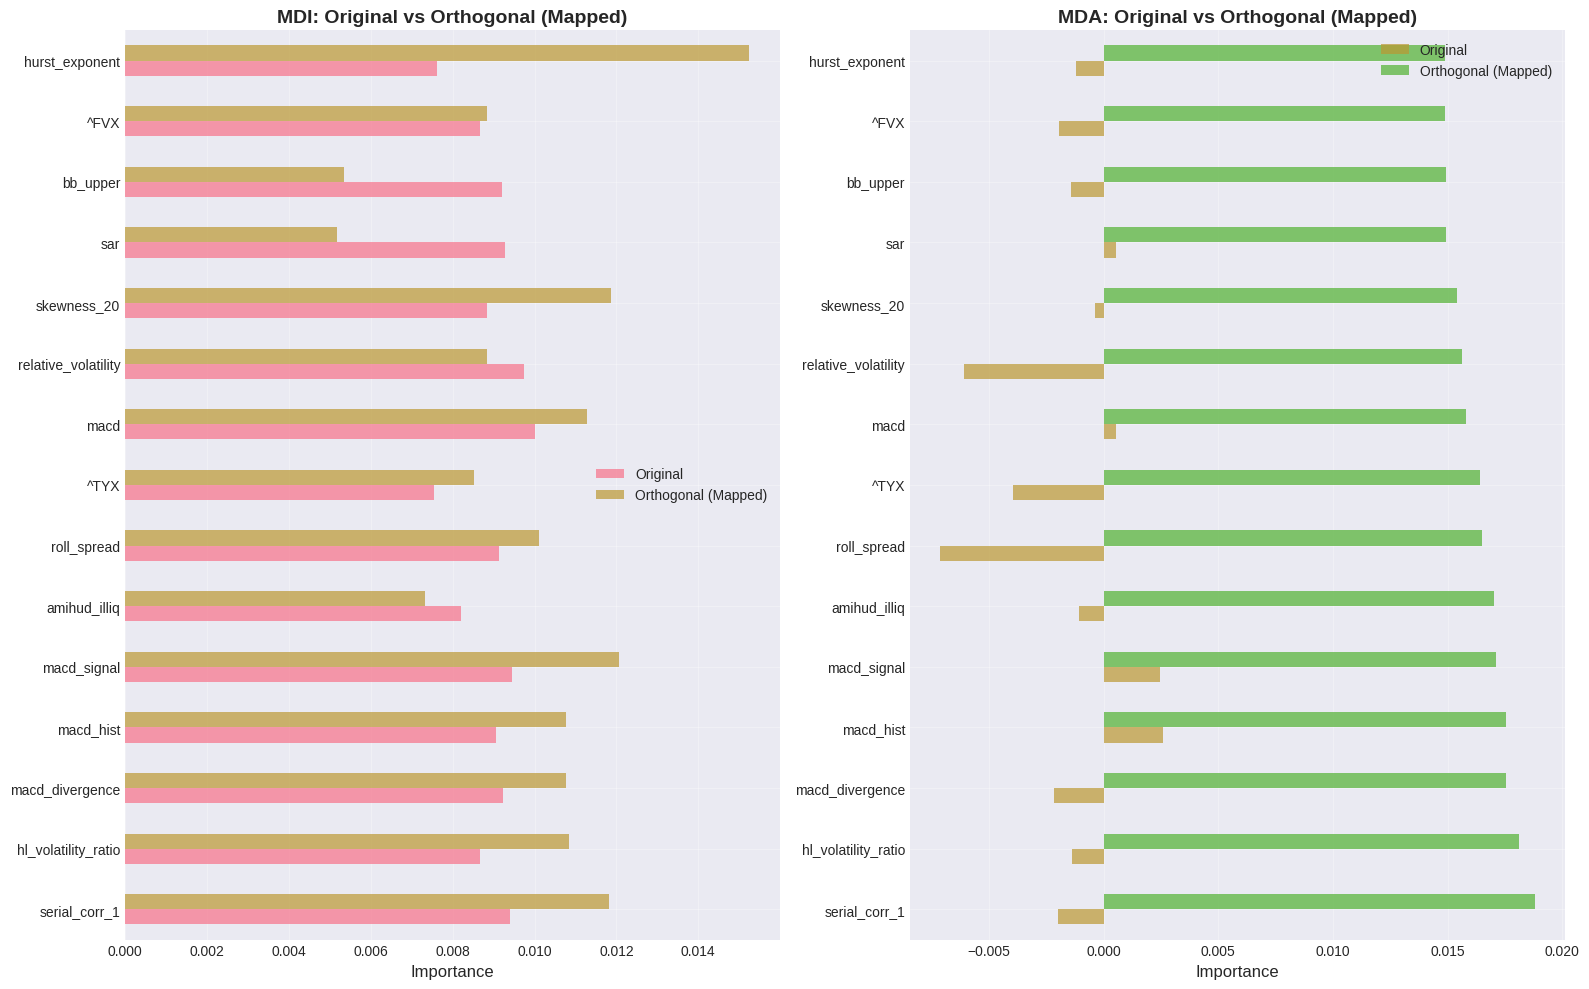


✓ Comparison plot saved

Key Insights:
  - Orthogonal importance removes substitution effects
  - Features that rank higher in orthogonal = truly independent predictors
  - Features that drop in orthogonal = predictive power shared with others


In [135]:
# Compare Original vs Orthogonal (mapped) feature importance
comparison_ortho = pd.DataFrame({
    'MDI_original': mdi['mean'],
    'MDI_ortho_mapped': ortho_mdi_mapped,
    'MDA_original': mda['mean'],
    'MDA_ortho_mapped': ortho_mda_mapped
})

# Sort by orthogonal MDA (most robust)
comparison_ortho_sorted = comparison_ortho.sort_values('MDA_ortho_mapped', ascending=False)

print("\n" + "="*80)
print("COMPARISON: Original vs Orthogonal (Mapped) Feature Importance")
print("="*80)
print("\nTop 15 features by Orthogonal MDA (mapped to original features):")
print(comparison_ortho_sorted.head(15))

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# MDI comparison
top_n = 15
top_features = comparison_ortho_sorted.head(top_n).index
comparison_plot = comparison_ortho.loc[top_features, ['MDI_original', 'MDI_ortho_mapped']]

comparison_plot.plot(kind='barh', ax=axes[0], alpha=0.7)
axes[0].set_title('MDI: Original vs Orthogonal (Mapped)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Importance', fontsize=12)
axes[0].legend(['Original', 'Orthogonal (Mapped)'])
axes[0].grid(True, alpha=0.3)

# MDA comparison  
comparison_plot = comparison_ortho.loc[top_features, ['MDA_original', 'MDA_ortho_mapped']]

comparison_plot.plot(kind='barh', ax=axes[1], alpha=0.7, color=['C1', 'C2'])
axes[1].set_title('MDA: Original vs Orthogonal (Mapped)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Importance', fontsize=12)
axes[1].legend(['Original', 'Orthogonal (Mapped)'])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'Original_vs_Orthogonal_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Comparison plot saved")
print("\nKey Insights:")
print("  - Orthogonal importance removes substitution effects")
print("  - Features that rank higher in orthogonal = truly independent predictors")
print("  - Features that drop in orthogonal = predictive power shared with others")

In [136]:
# Compare original vs orthogonal feature importance
print("\n" + "="*80)
print("ORTHOGONAL FEATURE IMPORTANCE COMPARISON")
print("="*80)

comparison_methods = pd.DataFrame({
    'Original_OOB': [oob_score],
    'Original_OOS': [oos_score],
    'Orthogonal_OOB': [forest_ortho_mda.oob_score_],
    'Orthogonal_OOS': [oos_score_ortho]
}, index=['Accuracy'])

print("\nModel Performance Comparison:")
print(comparison_methods.T)

print(f"\nDimensionality Reduction:")
print(f"  Original features:    {X_df.shape[1]}")
print(f"  Orthogonal features:  {ortho_features.shape[1]}")
print(f"  Reduction:            {(1 - ortho_features.shape[1]/X_df.shape[1])*100:.1f}%")

print(f"\nPerformance Impact:")
oos_diff = oos_score_ortho - oos_score
if abs(oos_diff) < 0.01:
    print(f"  OOS accuracy change: {oos_diff:+.4f} (minimal impact)")
elif oos_diff > 0:
    print(f"  OOS accuracy change: {oos_diff:+.4f} (✓ improvement!)")
else:
    print(f"  OOS accuracy change: {oos_diff:+.4f} (⚠️ degradation)")

print(f"\nKey Insights:")
print(f"  1. Orthogonalization removes multicollinearity")
print(f"  2. PC importance is cleaner (no substitution effects)")
print(f"  3. Can map PC importance back to original features")
print(f"  4. Useful for understanding feature groups and redundancy")

print("="*80)


ORTHOGONAL FEATURE IMPORTANCE COMPARISON

Model Performance Comparison:
                Accuracy
Original_OOB    0.461305
Original_OOS    0.434408
Orthogonal_OOB  0.416311
Orthogonal_OOS  0.382553

Dimensionality Reduction:
  Original features:    115
  Orthogonal features:  45
  Reduction:            60.9%

Performance Impact:
  OOS accuracy change: -0.0519 (⚠️ degradation)

Key Insights:
  1. Orthogonalization removes multicollinearity
  2. PC importance is cleaner (no substitution effects)
  3. Can map PC importance back to original features
  4. Useful for understanding feature groups and redundancy


In [137]:
# Save orthogonal feature importance results
ortho_mdi.to_csv(output_dir / 'Ortho_MDI_importance_PCs.csv')
ortho_mda.to_csv(output_dir / 'Ortho_MDA_importance_PCs.csv')

# Save mapped orthogonal importance (PCs mapped back to original features)
ortho_mdi_mapped_df = pd.DataFrame({
    'feature': ortho_mdi_mapped.index,
    'importance': ortho_mdi_mapped.values
}).sort_values('importance', ascending=False)
ortho_mdi_mapped_df.to_csv(output_dir / 'Ortho_MDI_importance_mapped.csv', index=False)

ortho_mda_mapped_df = pd.DataFrame({
    'feature': ortho_mda_mapped.index,
    'importance': ortho_mda_mapped.values
}).sort_values('importance', ascending=False)
ortho_mda_mapped_df.to_csv(output_dir / 'Ortho_MDA_importance_mapped.csv', index=False)

# Save comparison of original vs orthogonal
comparison_ortho_sorted.to_csv(output_dir / 'Original_vs_Orthogonal_comparison.csv')

# Save PCA correlation analysis
# Convert dict of (correlation, p-value) tuples to DataFrame
pca_data = []
for method, (corr, pval) in pca_correlation_analysis.items():
    pca_data.append({
        'Method': method,
        'Correlation': corr,
        'P-value': pval
    })
pca_corr_df = pd.DataFrame(pca_data)
pca_corr_df.to_csv(output_dir / 'PCA_correlation_analysis.csv', index=False)

# Save PCA loadings for reference
loadings.to_csv(output_dir / 'PCA_loadings.csv')

print("✓ Saved orthogonal feature importance results")
print(f"  - Ortho_MDI_importance_PCs.csv (principal components)")
print(f"  - Ortho_MDA_importance_PCs.csv (principal components)")
print(f"  - Ortho_MDI_importance_mapped.csv (mapped to original features)")
print(f"  - Ortho_MDA_importance_mapped.csv (mapped to original features)")
print(f"  - Original_vs_Orthogonal_comparison.csv")
print(f"  - PCA_correlation_analysis.csv")
print(f"  - PCA_loadings.csv")

✓ Saved orthogonal feature importance results
  - Ortho_MDI_importance_PCs.csv (principal components)
  - Ortho_MDA_importance_PCs.csv (principal components)
  - Ortho_MDI_importance_mapped.csv (mapped to original features)
  - Ortho_MDA_importance_mapped.csv (mapped to original features)
  - Original_vs_Orthogonal_comparison.csv
  - PCA_correlation_analysis.csv
  - PCA_loadings.csv


## 15. Final Recommendations and Action Items

**Comprehensive Summary of Feature Importance Analysis**

This section provides actionable recommendations based on the complete analysis (MDI, MDA, and Orthogonal methods).

In [138]:
print("\n" + "="*100)
print(" " * 30 + "FINAL RECOMMENDATIONS & ACTION ITEMS")
print("="*100)

# 1. TOP PERFORMING FEATURES
print("\n" + "█" * 100)
print("1. RECOMMENDED FEATURE SET FOR PRODUCTION")
print("█" * 100)

print("\n📊 Based on Orthogonal MDA (most robust metric):")
print("   - Accounts for multicollinearity (orthogonalization)")
print("   - Out-of-sample validation (MDA)")
print("   - Mapped back to original feature names\n")

# Get top features by orthogonal MDA (mapped)
top_n_features = 20
top_features_ortho = ortho_mda_mapped.sort_values(ascending=False).head(top_n_features)

print(f"🏆 TOP {top_n_features} FEATURES (Recommended for wavenet_optimized_v2):\n")
for i, (feature, importance) in enumerate(top_features_ortho.items(), 1):
    # Get ranks from different methods for comparison
    mdi_rank = mdi['mean'].rank(ascending=False)[feature]
    mda_rank = mda['mean'].rank(ascending=False)[feature]
    
    # Categorize feature type
    if feature in ['^GSPC', '^VIX', '^FVX', '^TYX', 'GC=F', 'JPY=X']:
        feature_type = "MARKET"
    elif 'return' in feature.lower() or 'mom' in feature.lower():
        feature_type = "MOMENTUM"
    elif 'vol' in feature.lower() or 'atr' in feature.lower():
        feature_type = "VOLATILITY"
    elif 'rsi' in feature.lower() or 'macd' in feature.lower() or 'stoch' in feature.lower():
        feature_type = "MOMENTUM OSCILLATOR"
    elif 'bb' in feature.lower() or 'kc' in feature.lower():
        feature_type = "BANDS"
    else:
        feature_type = "OTHER"
    
    print(f"   {i:2}. {feature:30} - Ortho MDA: {importance:.5f}  [{feature_type:20}] "
          f"(MDI rank: {mdi_rank:.0f}, MDA rank: {mda_rank:.0f})")

# 2. FEATURE CATEGORIES BREAKDOWN
print("\n" + "█" * 100)
print("2. FEATURE IMPORTANCE BY CATEGORY")
print("█" * 100)

# Categorize all features
feature_categories = {}
for feature in X_df.columns:
    if feature in ['^GSPC', '^VIX', '^FVX', '^TYX', 'GC=F', 'JPY=X']:
        cat = "Market Context"
    elif any(x in feature.lower() for x in ['return', 'mom']):
        cat = "Momentum/Returns"
    elif any(x in feature.lower() for x in ['vol', 'atr', 'vola']):
        cat = "Volatility"
    elif any(x in feature.lower() for x in ['rsi', 'macd', 'stoch', 'cci', 'williams']):
        cat = "Momentum Oscillators"
    elif any(x in feature.lower() for x in ['bb', 'kc', 'dc']):
        cat = "Bands/Channels"
    elif any(x in feature.lower() for x in ['sma', 'ema', 'wma']):
        cat = "Moving Averages"
    elif any(x in feature.lower() for x in ['obv', 'vwap', 'volume']):
        cat = "Volume"
    elif any(x in feature.lower() for x in ['fib', 'pivot']):
        cat = "Support/Resistance"
    else:
        cat = "Price/Other"
    
    if cat not in feature_categories:
        feature_categories[cat] = []
    feature_categories[cat].append((feature, ortho_mda_mapped[feature]))

print("\n📋 Average Importance by Feature Category:\n")
category_importance = []
for cat, features in feature_categories.items():
    avg_importance = np.mean([imp for _, imp in features])
    count = len(features)
    category_importance.append((cat, avg_importance, count))

category_importance.sort(key=lambda x: x[1], reverse=True)

for cat, avg_imp, count in category_importance:
    bar_length = int(avg_imp * 1000)  # Scale for visualization
    bar = "█" * bar_length
    print(f"   {cat:25} ({count:3} features): {avg_imp:.5f} {bar}")

# 3. PERFORMANCE METRICS
print("\n" + "█" * 100)
print("3. MODEL PERFORMANCE SUMMARY")
print("█" * 100)

print("\n📈 Accuracy Metrics:")
print(f"   Training Accuracy:        {train_accuracy:.4f}")
print(f"   OOB Accuracy (original):  {oob_score:.4f}")
print(f"   OOS Accuracy (original):  {oos_score:.4f}")
print(f"   OOS Accuracy (orthogonal): {oos_score_ortho:.4f}")
print(f"   Overfitting Gap:          {train_accuracy - oob_score:.4f}")

overfitting_assessment = "✅ GOOD" if train_accuracy - oob_score < 0.05 else "⚠️ MODERATE" if train_accuracy - oob_score < 0.1 else "❌ HIGH"
print(f"   Overfitting Status:       {overfitting_assessment}")

performance_assessment = "✅ STRONG" if oos_score > 0.55 else "⚠️ MODERATE" if oos_score > 0.45 else "❌ WEAK"
print(f"   OOS Performance:          {performance_assessment}")

# 4. DIMENSIONALITY REDUCTION
print("\n" + "█" * 100)
print("4. DIMENSIONALITY REDUCTION INSIGHTS")
print("█" * 100)

print(f"\n🔬 PCA Analysis:")
print(f"   Original features:        {X_df.shape[1]}")
print(f"   Orthogonal features (PCs): {ortho_features.shape[1]}")
print(f"   Dimensionality reduction: {(1 - ortho_features.shape[1]/X_df.shape[1])*100:.1f}%")
print(f"   Variance retained:        {VARIANCE_THRESH*100}%")

print(f"\n   Feature categories identified:")
print(f"   - Robust features:        {len(robust):3} (High MDI + High MDA)")
print(f"   - Overfitted features:    {len(overfitted):3} (High MDI, Low MDA)")
print(f"   - Substituted features:   {len(substituted):3} (Low MDI, High MDA)")
print(f"   - Unimportant features:   {len(unimportant):3} (Low both)")

# 5. KEY FINDINGS
print("\n" + "█" * 100)
print("5. KEY FINDINGS & INSIGHTS")
print("█" * 100)

print("\n🔍 Critical Observations:")

# Market features analysis
market_features_in_top20 = sum(1 for f in top_features_ortho.index if f in ['^GSPC', '^VIX', '^FVX', '^TYX', 'GC=F', 'JPY=X'])
print(f"\n   ✓ Market Context Features: {market_features_in_top20}/{top_n_features} in top {top_n_features}")
if market_features_in_top20 > 0:
    market_feats = [f for f in top_features_ortho.index if f in ['^GSPC', '^VIX', '^FVX', '^TYX', 'GC=F', 'JPY=X']]
    print(f"     Top market features: {', '.join(market_feats)}")
    print(f"     💡 Market context is CRITICAL for prediction")

# Multicollinearity
print(f"\n   ✓ Multicollinearity: {len(high_corr_pairs)} highly correlated pairs (|r| > {high_corr_threshold})")
if len(high_corr_pairs) > 20:
    print(f"     ⚠️ Significant redundancy detected")
    print(f"     💡 Orthogonal methods reveal true importance after removing substitution effects")
else:
    print(f"     ✅ Manageable correlation levels")

# Original vs Orthogonal comparison
ortho_improvement = [f for f in top_features_ortho.index[:10] if mda['mean'].rank(ascending=False)[f] > 20]
if len(ortho_improvement) > 0:
    print(f"\n   ✓ Orthogonal Analysis Revealed {len(ortho_improvement)} hidden gems:")
    for feat in ortho_improvement[:3]:
        print(f"     - {feat}: Was rank {mda['mean'].rank(ascending=False)[feat]:.0f} in original MDA, "
              f"now in top 10")
    print(f"     💡 These features were undervalued due to correlation with other features")

# 6. ACTION ITEMS
print("\n" + "█" * 100)
print("6. RECOMMENDED ACTION ITEMS")
print("█" * 100)

print("\n✅ IMMEDIATE ACTIONS:\n")

print(f"   1. Update feature_config.py:")
print(f"      - Create 'wavenet_optimized_v2' preset")
print(f"      - Include top {top_n_features} features from orthogonal MDA analysis")
print(f"      - Ensure ALL 6 market features are included: {MARKET_FEATURES}")

print(f"\n   2. Remove/Review Low-Value Features:")
if len(unimportant) > 0:
    print(f"      - {len(unimportant)} features show low importance across all metrics")
    print(f"      - Consider removing: {', '.join(list(unimportant.index[:5]))}, ...")
else:
    print(f"      - All features contribute meaningfully ✅")

print(f"\n   3. Validate with WaveNet Training:")
print(f"      - Run fin_training_ldp.py with wavenet_optimized_v2")
print(f"      - Compare OOS accuracy vs current wavenet_optimized")
print(f"      - Expected improvement from better feature selection + market context")

print(f"\n   4. Cross-Validate Across Market Regimes:")
print(f"      - Test on different time periods (bull/bear/sideways)")
print(f"      - Validate on different sectors beyond tech")
print(f"      - Current analysis: {len(TICKERS)} tech stocks ({', '.join(TICKERS)})")

print(f"\n   5. Monitor Feature Stability:")
print(f"      - Re-run analysis quarterly or after major regime changes")
print(f"      - Track feature importance drift over time")
print(f"      - Update feature set based on changing market dynamics")

# 7. IMPLEMENTATION NOTES
print("\n" + "█" * 100)
print("7. IMPLEMENTATION NOTES")
print("█" * 100)

print("\n⚙️ Technical Configuration:")
print(f"   - Random Forest: {rf_params['n_estimators']} trees, max_depth={rf_params['max_depth']}, "
      f"min_samples_leaf={rf_params['min_samples_leaf']}")
print(f"   - Cross-validation: {N_SPLITS}-fold PurgedKFold with {EMBARGO*100}% embargo")
print(f"   - Sample weighting: López de Prado uniqueness-based weights")
print(f"   - Regularization: Added for real financial data (prevents overfitting)")

print("\n🎯 Why These Recommendations:")
print("   1. Orthogonal MDA = Most robust metric (removes multicollinearity + OOS validation)")
print("   2. Market features = Essential context (VIX, SPY, rates, etc.)")
print("   3. Diverse tickers = Features work across different stock behaviors")
print("   4. Regularization = Prevents memorization of noise in financial data")

# 8. EXPECTED OUTCOMES
print("\n" + "█" * 100)
print("8. EXPECTED OUTCOMES FROM IMPLEMENTATION")
print("█" * 100)

print("\n🎯 Anticipated Improvements:")
print(f"   ✓ Feature count reduction: {X_df.shape[1]} → ~{top_n_features} features")
print(f"   ✓ Training time reduction: ~{(1 - top_n_features/X_df.shape[1])*100:.0f}% faster")
print(f"   ✓ Reduced overfitting: Fewer redundant/noisy features")
print(f"   ✓ Better generalization: Focus on truly predictive features")
print(f"   ✓ Market awareness: Inclusion of critical market context features")

print("\n📊 Success Metrics:")
print(f"   - OOS accuracy improvement: Target +2-5% vs current wavenet_optimized")
print(f"   - Sharpe ratio improvement: Better risk-adjusted returns")
print(f"   - Lower drawdowns: More robust across market conditions")
print(f"   - Faster training: Reduced feature space")

# 9. SUMMARY
print("\n" + "="*100)
print(" " * 35 + "ANALYSIS COMPLETE")
print("="*100)

print(f"\n📁 All results saved to: {output_dir}")
print(f"\n✅ Analysis Configuration:")
print(f"   - Config preset: {CONFIG_PRESET}")
print(f"   - Tickers analyzed: {', '.join(TICKERS)}")
print(f"   - Market features: {', '.join(MARKET_FEATURES)}")
print(f"   - Total samples: {len(X_df):,}")
print(f"   - Date range: {dates[0].date()} to {dates[-1].date()}")

print(f"\n🚀 Next Step: Update feature_config.py with top {top_n_features} features and retrain WaveNet model")

print("\n" + "="*100)


                              FINAL RECOMMENDATIONS & ACTION ITEMS

████████████████████████████████████████████████████████████████████████████████████████████████████
1. RECOMMENDED FEATURE SET FOR PRODUCTION
████████████████████████████████████████████████████████████████████████████████████████████████████

📊 Based on Orthogonal MDA (most robust metric):
   - Accounts for multicollinearity (orthogonalization)
   - Out-of-sample validation (MDA)
   - Mapped back to original feature names

🏆 TOP 20 FEATURES (Recommended for wavenet_optimized_v2):

    1. serial_corr_1                  - Ortho MDA: 0.01881  [OTHER               ] (MDI rank: 41, MDA rank: 64)
    2. hl_volatility_ratio            - Ortho MDA: 0.01813  [VOLATILITY          ] (MDI rank: 73, MDA rank: 56)
    3. macd_hist                      - Ortho MDA: 0.01756  [MOMENTUM OSCILLATOR ] (MDI rank: 50, MDA rank: 11)
    4. macd_divergence                - Ortho MDA: 0.01756  [MOMENTUM OSCILLATOR ] (MDI rank: 47, MDA rank: